## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

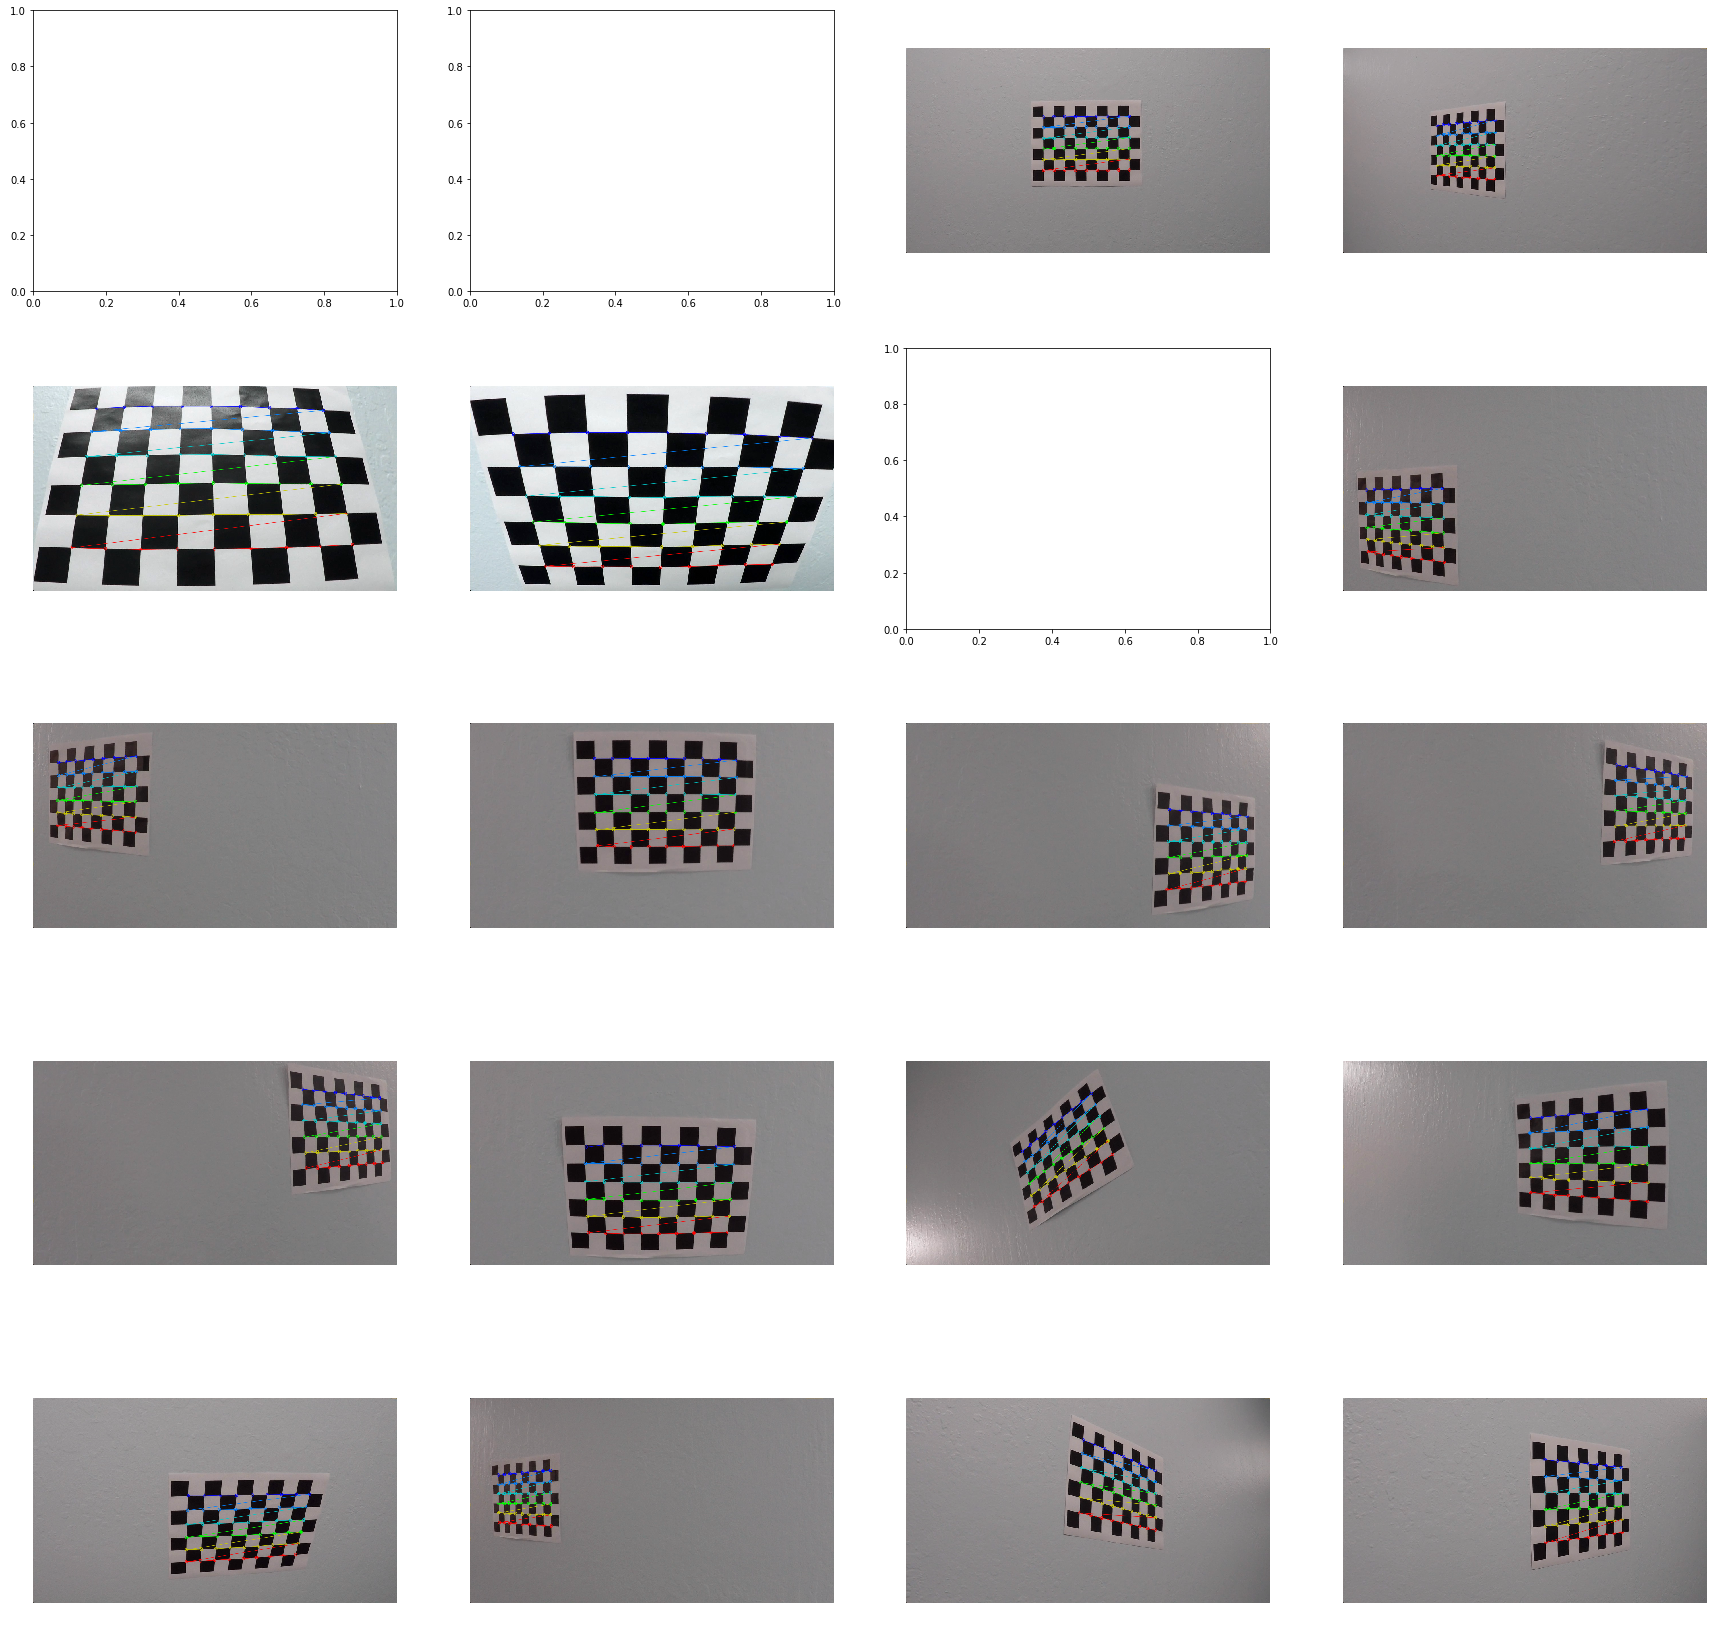

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

from ipywidgets import interact, interactive, fixed

%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

fig, axes = plt.subplots(5,4, figsize=(30, 30))
axes = axes.ravel()

# Step through the list and search for chessboard corners
for i,fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        axes[i].axis('off')
        axes[i].imshow(img)

## Camera Calibration and Saving up the required parameters

In [4]:
img = cv2.imread('./camera_cal/calibration10.jpg')
#img_size = (img.shape[1], img.shape[0])

#Camera calibration, given object points, image points, and the shape of the grayscale image:

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

undist = cv2.undistort(img, mtx, dist, None, mtx)

# Saving the camera calibration parameters
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
dist_pickle["rvecs"] = rvecs
dist_pickle["tvecs"] = tvecs
pickle.dump( dist_pickle, open( "CameraCalibration.p", "wb" ) )

# Making a method for the pipeline that will be made in later section
def undistort(img):
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img

## Undistorting images using above camera calibration

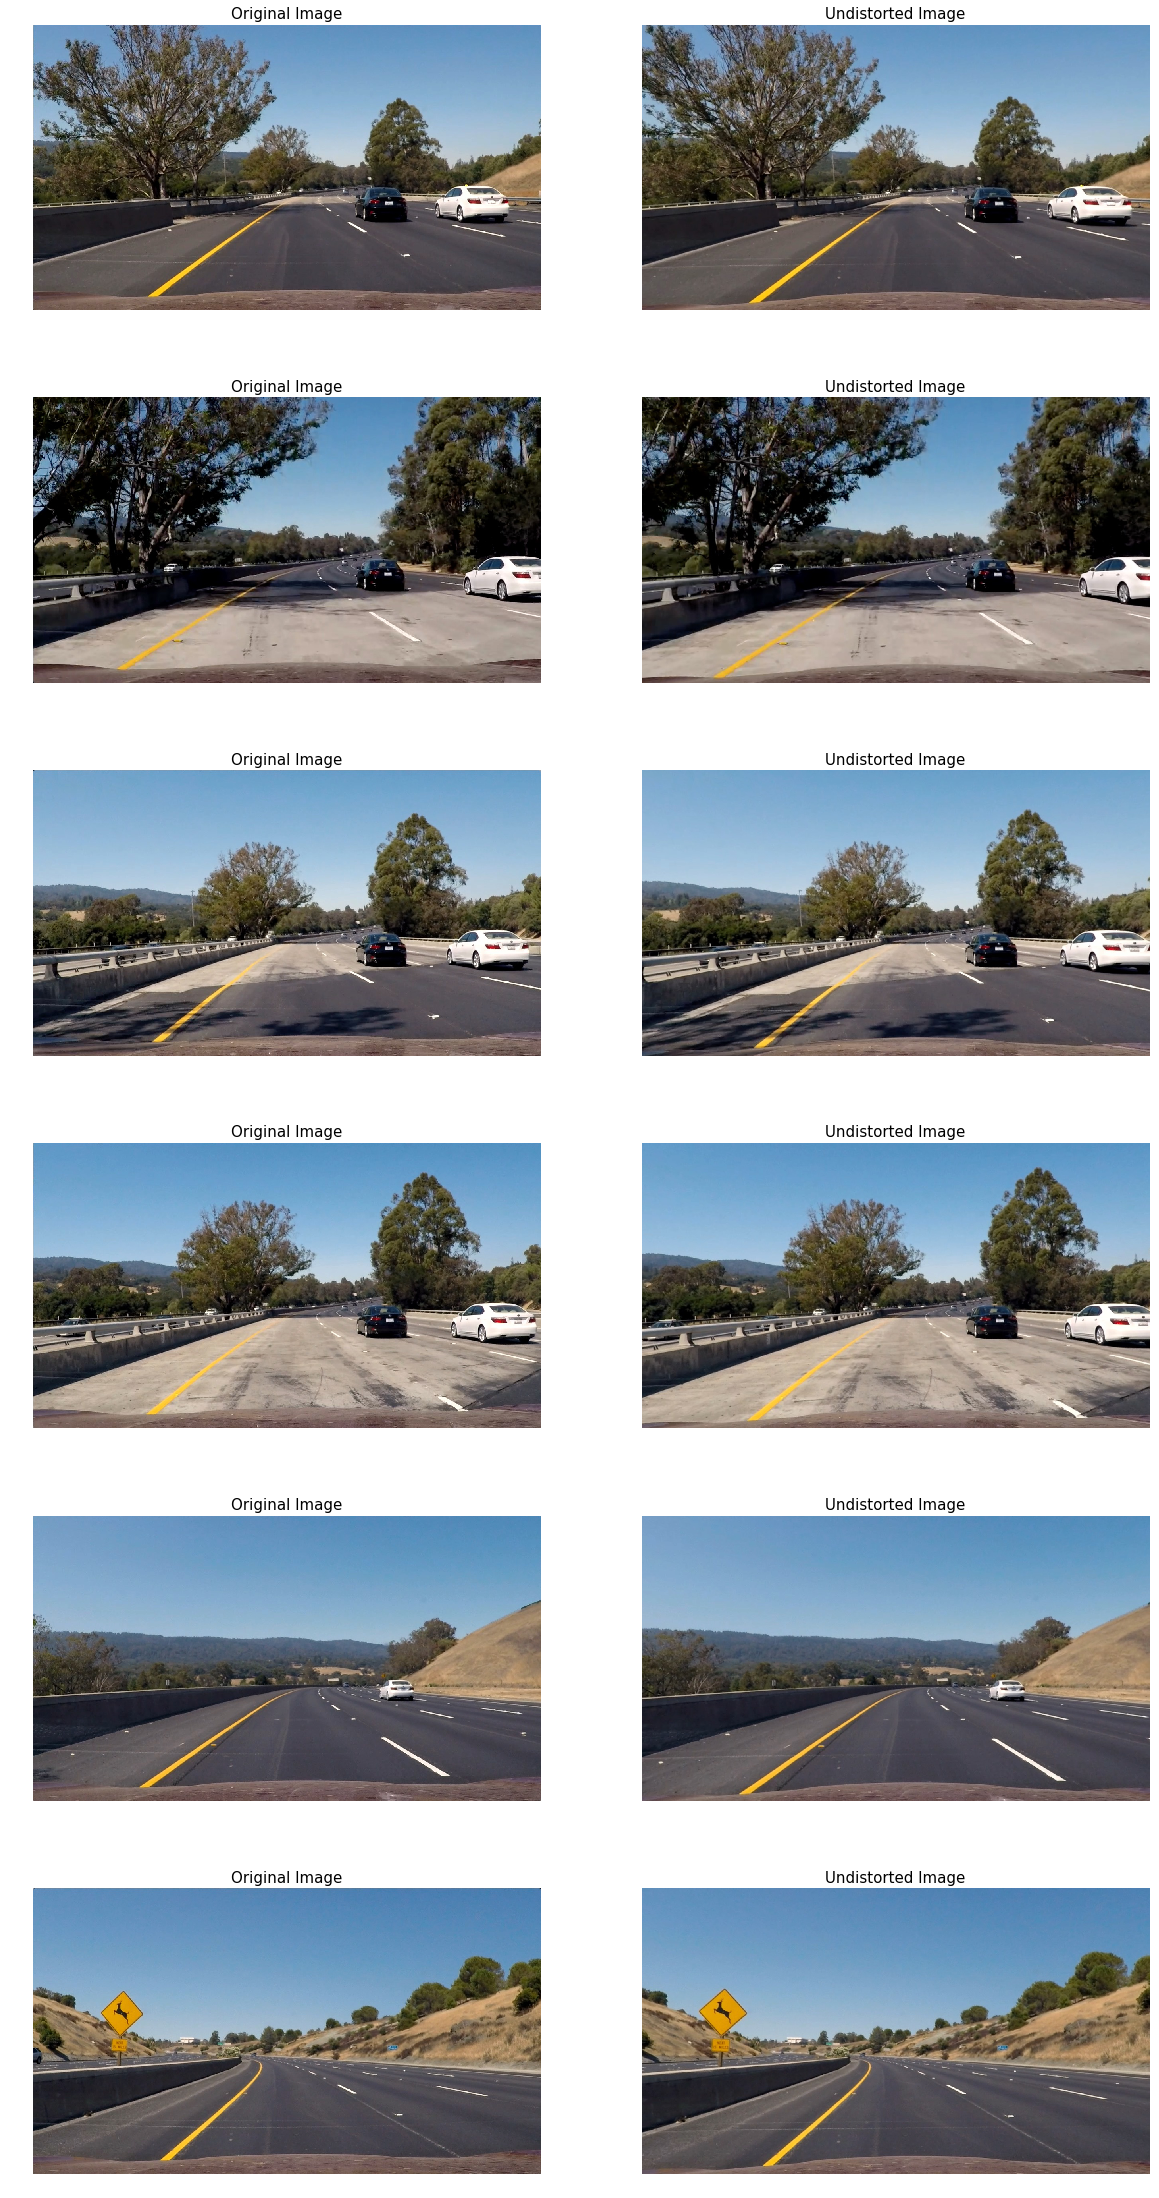

In [5]:

# list of test images
images = glob.glob('test_images/test*.jpg')

f, axarr = plt.subplots(6, 2, figsize=(20, 40))
undist_images = []

#Undistorting a test image:
for i, fname in enumerate(images):
    img = mpimg.imread(fname,0) 
    undist = cv2.undistort(img, mtx, dist, None, mtx) 
    undist_images.append(undist)
    axarr[i,0].axis('off')
    axarr[i,0].set_title('Original Image', fontsize=15)
    axarr[i,0].imshow(img)
    axarr[i,1].axis('off')
    axarr[i,1].set_title('Undistorted Image', fontsize=15)
    axarr[i,1].imshow(undist)

## Defining color space thresholding function

In [6]:
# HLS Color space
def hls_color_thresh(img, threshLow, threshHigh):
    imgHLS = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    binary_output = np.zeros((img.shape[0], img.shape[1]))
    binary_output[(imgHLS[:,:,0] >= threshLow[0]) & (imgHLS[:,:,0] <= threshHigh[0]) & (imgHLS[:,:,1] >= threshLow[1])  & (imgHLS[:,:,1] <= threshHigh[1])  & (imgHLS[:,:,2] >= threshLow[2]) & (imgHLS[:,:,2] <= threshHigh[2])] = 1
    return binary_output

## Applying Sobel transform and thresholding to undistorted image

In [7]:
#Sobel in x direction & Magnitude threshold
def sobel_x(img, sobel_kernel=3,min_thres = 20, max_thres =100):
    # Apply the following steps to img
    # 1) Convert to grayscale
    imghsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Take the gradient in x and y separately
    #Channels L and S from HLS
    sobelx1 = cv2.Sobel(imghsl[:,:,1], cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobelx2 = cv2.Sobel(imghsl[:,:,2], cv2.CV_64F, 1,0, ksize=sobel_kernel)
        
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobelx1 = np.uint8(255*sobelx1/ np.max(sobelx1))
    scaled_sobelx2 = np.uint8(255*sobelx2/ np.max(sobelx2))

    # 5) Create a binary mask where mag thresholds are met
    binary_outputx1 = np.zeros_like(scaled_sobelx1)
    binary_outputx1[(scaled_sobelx1 >= min_thres) & (scaled_sobelx1 <= max_thres)] = 1

    binary_outputx2 = np.zeros_like(scaled_sobelx2)
    binary_outputx2[(scaled_sobelx2 >= min_thres) & (scaled_sobelx2 <= max_thres)] = 1

    binary_output = np.zeros_like(scaled_sobelx1)
    binary_output[(binary_outputx1 ==1) | (binary_outputx2 ==1)]=1
    # 6) Return this mask as your binary_output image
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*gradmag / np.max(gradmag))
       
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1


    # 6) Return this mask as your binary_output image
    return binary_output


#Direction threshold
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)

    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(abs_sobely, abs_sobelx) 

    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    return binary_output

#Both Magnitude and direction threshold
def mag_dir_thresh(img, sobel_kernel=3, mag_thresh=(0, 255), dir_thresh=(0,np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1,0, ksize=sobel_kernel) 
    sobely = cv2.Sobel(img, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    #Calc angle
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    absgraddir = np.arctan2(abs_sobely, abs_sobelx) 

    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*gradmag / np.max(gradmag))
       
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1]) & (absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1]) ] = 1


    # 6) Return this mask as binary_output image
    return binary_output

## Examples of gradient and color thresholding

Examples of magnitude and direction thresholds


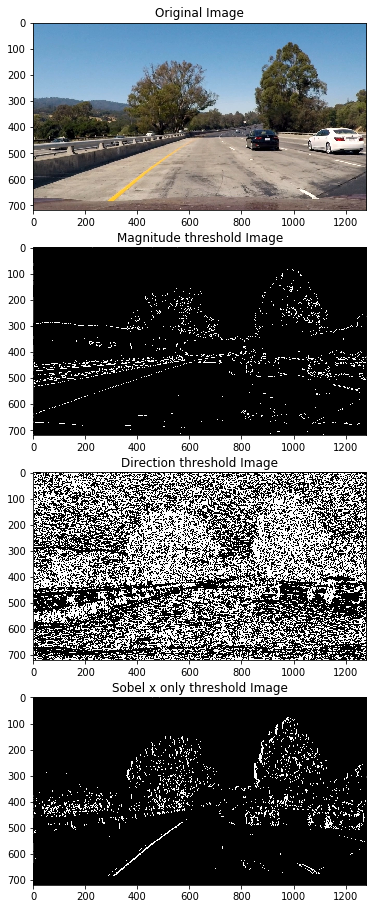

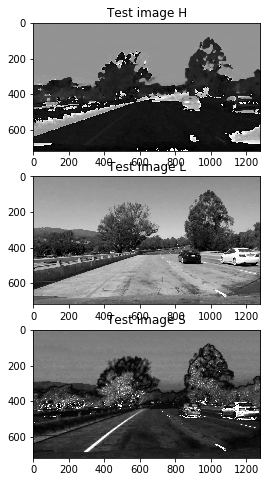

In [8]:
#Examples of magnitude and direction thresholds
plt.figure(figsize=(10,8))

img = cv2.imread("test_images/test1.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

magThr =mag_thresh(imgRGB, 3, (50, 100))

dirThr =dir_threshold(imgRGB, 9,(np.pi/240/90, np.pi/2*60/90))

#Sobel x only
imgThr = sobel_x(imgRGB,9,80,220) #Sobel x

print("Examples of magnitude and direction thresholds")
plt.figure(figsize=(40,20))

plt.subplot(5,1,1)
plt.title('Original Image')
fig =plt.imshow(imgRGB)

plt.subplot(5,1,2)
plt.title('Magnitude threshold Image')
fig =plt.imshow(magThr,cmap = 'gray')

plt.subplot(5,1,3)
plt.title('Direction threshold Image')
fig =plt.imshow(dirThr,cmap = 'gray')

plt.subplot(5,1,4)
plt.title('Sobel x only threshold Image')
fig =plt.imshow(imgThr,cmap = 'gray')

# on test images

img = cv2.imread("test_images/test1.jpg")
imgHLS = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

plt.figure(figsize=(10,8))

plt.subplot(3,1,1)
plt.title('Test image H')
fig =plt.imshow(imgHLS[:,:,0],cmap='gray')
plt.subplot(3,1,2)
plt.title('Test Image L')
fig =plt.imshow(imgHLS[:,:,1],cmap='gray')
plt.subplot(3,1,3)
plt.title('Test image S')
fig =plt.imshow(imgHLS[:,:,2],cmap='gray')

## Perspective transform and warped image

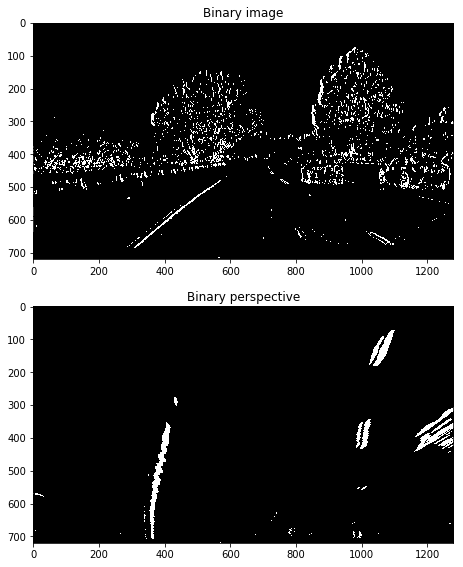

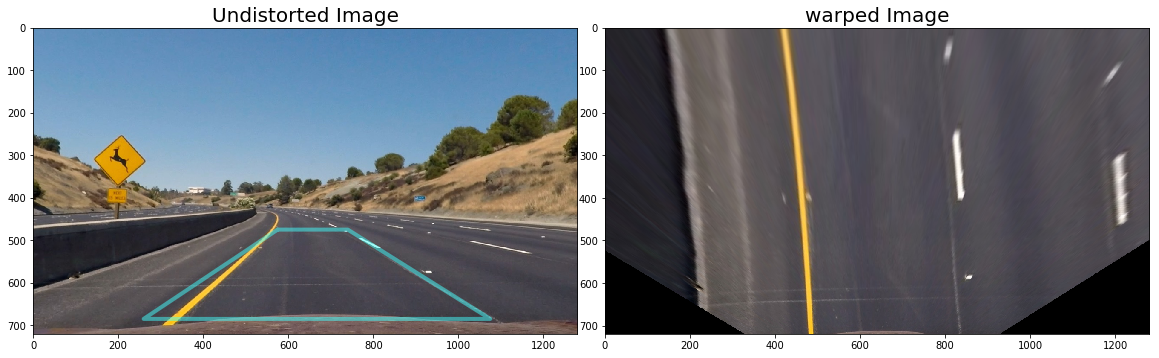

In [9]:
#Perspective transfomation

src = np.float32([[585, 450], [204, 720], [1126, 720], [695, 450]])
dst = np.float32([[320, 0], [320, 720], [960,720], [960, 0]])

M_persp = cv2.getPerspectiveTransform(src, dst)
Minv_persp = cv2.getPerspectiveTransform(dst, src)

img_size = (imgThr.shape[1], imgThr.shape[0])
binary_warped = cv2.warpPerspective(imgThr, M_persp, img_size, flags=cv2.INTER_LINEAR)


plt.figure(figsize=(30,20))

plt.subplot(4,1,1)
plt.title('Binary image')
fig =plt.imshow(imgThr, cmap='gray')

plt.subplot(4,1,2)
plt.title('Binary perspective')
fig =plt.imshow(binary_warped, cmap='gray')

# Warp image

def warp(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv
    

h,w = undist_images[5].shape[:2]

# # define source and destination points for transform for test3.jpg
src = np.float32([(575,475),
                  (740,475), 
                  (260,685), 
                  (1075,685)])

dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])

undist_images_warp, M, Minv = warp(undist_images[5], src, dst)

# Visualize warp
f, (axes1, axes2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
axes1.imshow(undist_images[5])

x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]

axes1.plot(x,y, color='#44ffff', alpha=0.5, linewidth=4, solid_capstyle='round', zorder=2)
axes1.imshow(undist_images[5])
axes1.set_ylim([h,0])
axes1.set_xlim([0,w])
axes1.set_title('Undistorted Image', fontsize=20)

axes2.imshow(undist_images_warp)
axes2.set_title('warped Image', fontsize=20)

## Fit the lines found onto a polynomial

In [10]:
def fitlines(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
   
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit =[]
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
    
    if len(rightx) == 0:
        right_fit =[]
    else:
        right_fit = np.polyfit(righty, rightx, 2)
    

    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


    return left_fit, right_fit,out_img

(720, 1280, 3)
255.0


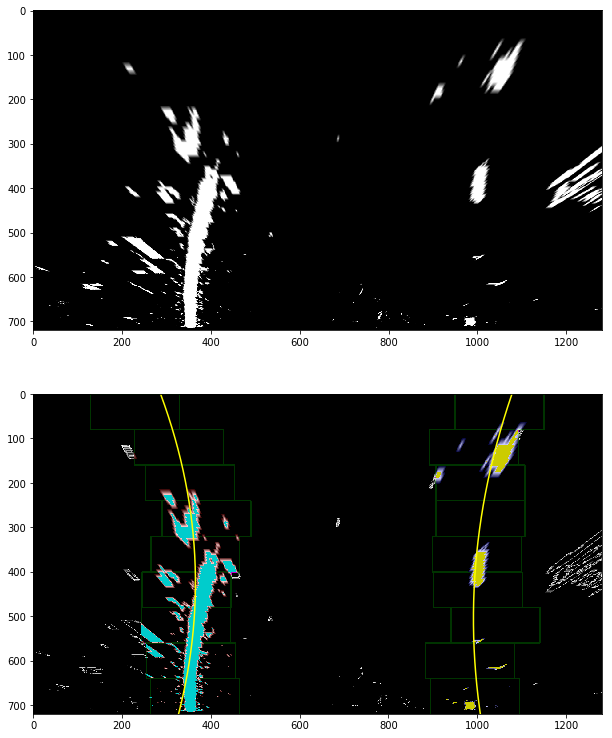

In [11]:
#Visualization of lines fitted
img = cv2.imread("test_images/test1.jpg")
#img = cv2.imread("test_images/straight_lines2.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_undist = cv2.undistort(imgRGB, mtx, dist, None, mtx)

#2.Magnitude Threshold
#Threshold color    
yellow_low = np.array([0,100,100])
yellow_high = np.array([50,255,255])
white_low = np.array([18,0,180])
white_high = np.array([255,80,255])
global ref_left 
global ref_right
global left_fit
global right_fit

imgThres_yellow = hls_color_thresh(img_undist,yellow_low,yellow_high)
imgThres_white = hls_color_thresh(img_undist,white_low,white_high)
imgThr_sobelx = sobel_x(img_undist,9,80,220) #Sobel x only

img_mag_thr =np.zeros_like(imgThres_yellow)
img_mag_thr[(imgThres_yellow==1) | (imgThres_white==1) | (imgThr_sobelx==1)] =1
img_mag_thr[(imgThres_yellow==1) | (imgThres_white==1)] =1


#3. Birds-eye
#Perspective array from before
img_size = (img_mag_thr.shape[1], img_mag_thr.shape[0])
binary_warped = cv2.warpPerspective(img_mag_thr, M_persp, img_size, flags=cv2.INTER_LINEAR)

left_fit, right_fit,out_img = fitlines(binary_warped)


print(out_img.shape)
print(np.max(out_img))


ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    

plt.figure(figsize=(30,20))
plt.subplot(3,1,1)
plt.imshow(binary_warped, cmap='gray')

plt.subplot(3,1,2)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.subplot(3,1,2)
binary_warped2 = np.zeros((720, 1280,3))
binary_warped2[:,:,0] = binary_warped
binary_warped2[:,:,1] = binary_warped
binary_warped2[:,:,2] = binary_warped
plt.imshow(out_img)
result = cv2.addWeighted(binary_warped2, .8, out_img, .8, 0)
plt.imshow(result)

In [12]:

def fit_continuous(left_fit, right_fit, binary_warped):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit_updated =[]
    else:
        left_fit_updated = np.polyfit(lefty, leftx, 2)
    
    
    if len(rightx) == 0:
        right_fit_updated =[]
    else:
        right_fit_updated = np.polyfit(righty, rightx, 2)
        
    return  left_fit_updated, right_fit_updated

## Calculate curvature

In [31]:
def curvature(left_fit, right_fit, binary_warped):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)
    
    # from estimate of US lane regulations (approx)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    leftx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    rightx = right_fit[0]*ploty**2+right_fit[1]*ploty+left_fit[2]
        
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    center = (((left_fit_cr[0]*720**2+left_fit_cr[1]*720+left_fit_cr[2]) +(right_fit_cr[0]*720**2+right_fit_cr[1]*720+right_fit_cr[2]) ) /2 - 640)*xm_per_pix
    
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    return left_curverad, right_curverad, center

## Draw fitted lane on image

In [32]:

def drawLine(undist, warped,left_fit, right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    # Fit new polynomials to x,y in world space
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 
    
    #print(left_fitx)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv_persp, (color_warp.shape[1], color_warp.shape[0])) 

    # Combine the result with the original image
    
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return(result, color_warp)

## Pipeline for image

In [33]:
global counter
counter=0
ref_left =np.array([-0.0001,0,400])
ref_right=np.array([-0.0001,0,1000])   
left_fit =np.array([-0.0001,0,400])
right_fit=np.array([-0.0001,0,1000])   

def process_image(image):
    #1. Camera correction
    #Calibration arrays pre-calculated
    img_undist = cv2.undistort(image, mtx, dist, None, mtx)
    global counter
    
    #2.Magnitude Threshold
    #Threshold color    
    yellow_low = np.array([0,100,100])
    yellow_high = np.array([50,255,255])
    white_low = np.array([18,0,180])
    white_high = np.array([255,80,255])
    global ref_left 
    global ref_right
    global left_fit
    global right_fit

    imgThres_yellow = hls_color_thresh(img_undist,yellow_low,yellow_high)
    imgThres_white = hls_color_thresh(img_undist,white_low,white_high)
    imgThr_sobelx = sobel_x(img_undist,9,80,220) #Sobel x

    img_mag_thr =np.zeros_like(imgThres_yellow)
    #imgThresColor[(imgThres_yellow==1) | (imgThres_white==1)] =1
    img_mag_thr[(imgThres_yellow==1) | (imgThres_white==1) | (imgThr_sobelx==1)] =1
        
    #3. Birds-eye
    #Perspective array pre-calculated
    img_size = (img_mag_thr.shape[1], img_mag_thr.shape[0])
    binary_warped = cv2.warpPerspective(img_mag_thr, M_persp, img_size, flags=cv2.INTER_LINEAR)
    
    #4. Detect lanes and return fit curves
    
    if counter==0:
        left_fit, right_fit,out_imgfit = fitlines(binary_warped)
    else:
        left_fit, right_fit = fit_continuous(left_fit, right_fit, binary_warped)
    
    status_sanity, d0, d1 =sanity_check(left_fit, right_fit, 0, .55)  
    #Calc curvature and center
    if status_sanity  == True:        
        #Save as last reliable fit
        ref_left, ref_right = left_fit, right_fit        
        counter+=1
    else:        #Use the last realible fit
        left_fit, right_fit = ref_left, ref_right
        
    left_curv, right_curv, center_off = curvature(left_fit, right_fit, binary_warped)

    #Warp back to original and merge with image    
    img_out, img_birds = drawLine(img_undist, binary_warped,left_fit, right_fit)

    
    #Write curvature and center in image
    TextL = "Left curv: " + str(int(left_curv)) + " m"
    TextR = "Right curv: " + str(int(right_curv))+ " m"
    TextC = "Center offset: " + str(round( center_off,2)) + "m"

    fontScale=1
    thickness=2
    
    fontFace = cv2.FONT_HERSHEY_SIMPLEX


    cv2.putText(img_out, TextL, (130,40), fontFace, fontScale,(200,255,155), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, TextR, (130,70), fontFace, fontScale,(200,255,155), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, TextC, (130,100), fontFace, fontScale,(200,255,155), thickness,  lineType = cv2.LINE_AA)
   
    return img_out

## Sanity check as instructed in rubric

In [34]:
def sanity_check(left_fit, right_fit, minSlope, maxSlope):
    #Performs a sanity check on the lanes
    #Check 1: check if left and right fits exists
    #Check 2: Calculates the tangent between left and right in two points, and check if it is in a reasonable threshold
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    if len(left_fit) ==0 or len(right_fit) == 0:
        status = False
        d0=0
        d1=0
        #Previous fitlines routine returns empty list to them if not finds
    else:
        #Difference of slope
        L_0 = 2*left_fit[0]*460+left_fit[1]
        R_0 = 2*right_fit[0]*460+right_fit[1]
        d0 =  np.abs(L_0-R_0)

        L_1 = 2*left_fit[0]*720+left_fit[1]
        R_1 = 2*right_fit[0]*720+right_fit[1]
        d1 =  np.abs(L_1-R_1)

        
        if d0>= minSlope and d0<= maxSlope and d1>= minSlope and d1<= maxSlope:
            status = True
        else:
            status = False
            
    return(status, d0, d1)

378.089418303 m 485.771238641 m


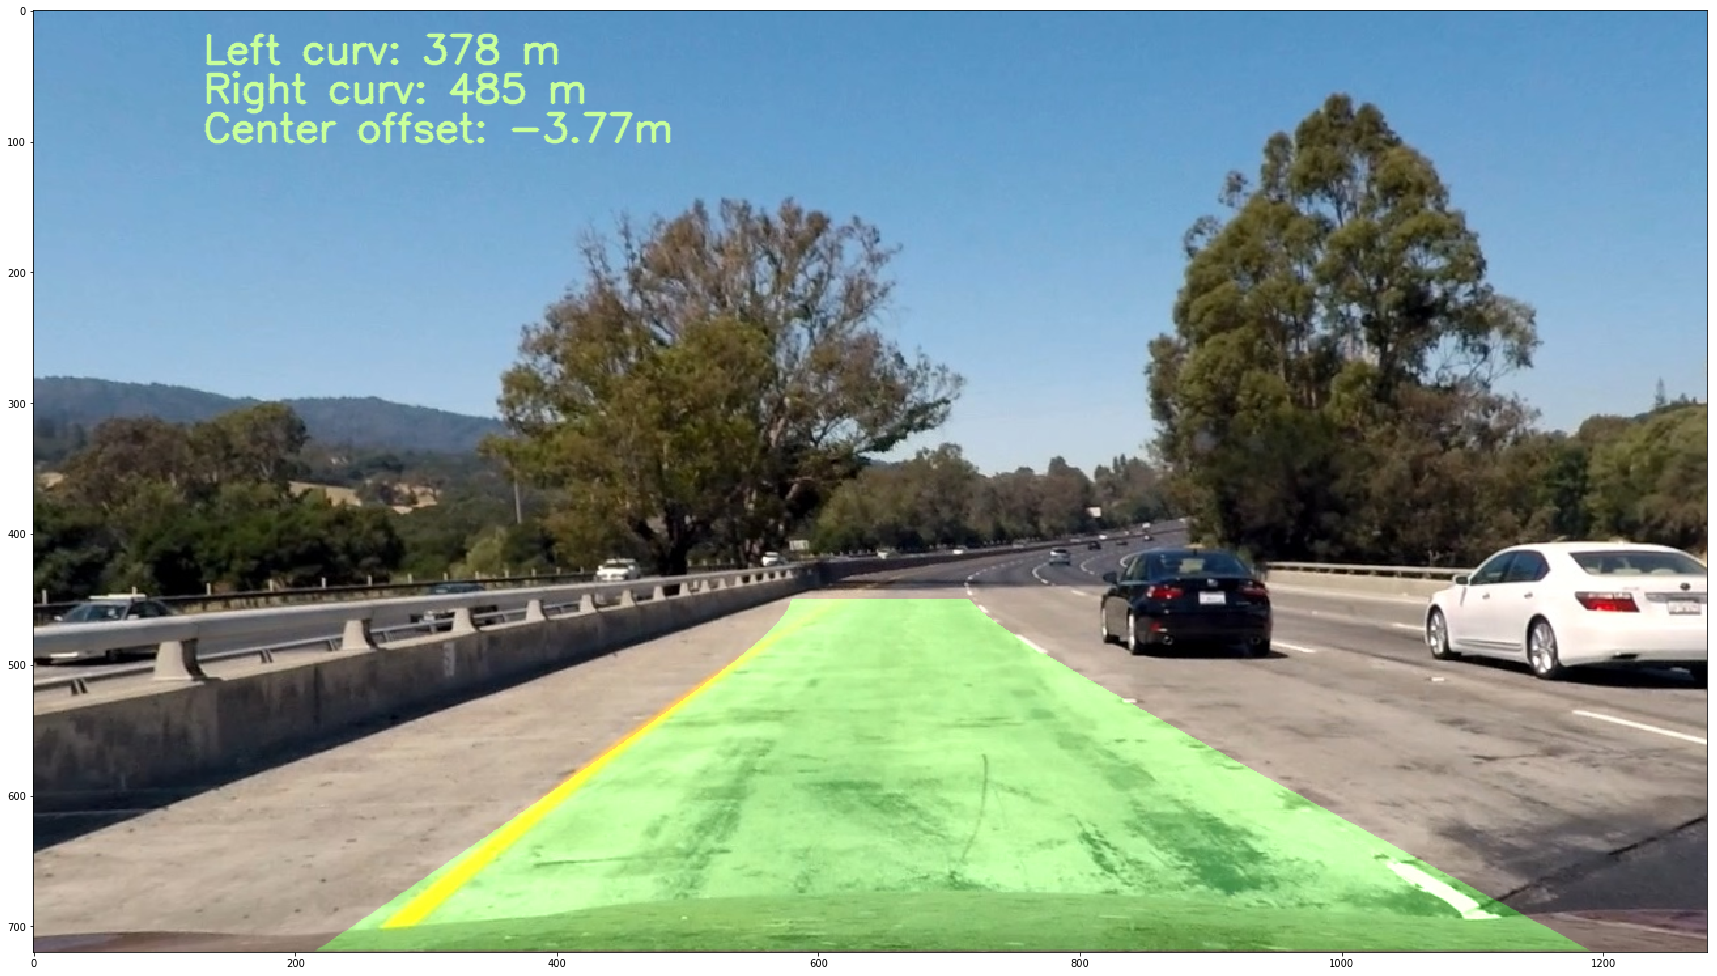

In [35]:
img = cv2.imread("test_images/test1.jpg")
#img = cv2.imread("test_images/straight_lines1.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img2= process_image(imgRGB)

plt.figure(figsize=(10,15))
#plt.figure(figsize=(5,10))

  
plt.figure(figsize=(30,20))
plt.imshow(img2)

## Video setup

In [36]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import moviepy as mve

In [37]:
#Create video file pipeline
counter=0
output = 'out_test_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
out_clip = clip1.fl_image(process_image)
%time out_clip.write_videofile(output, audio=False)
print(counter)

407.207237141 m 827.118386298 m
[MoviePy] >>>> Building video out_test_video.mp4
[MoviePy] Writing video out_test_video.mp4


  0%|          | 1/1261 [00:00<04:35,  4.57it/s]

407.207237141 m 827.118386298 m


  0%|          | 2/1261 [00:00<04:44,  4.43it/s]

404.042338811 m 618.070577244 m
405.140000464 m 639.269558986 m


  0%|          | 5/1261 [00:01<04:06,  5.10it/s]

411.235653131 m 545.312699406 m
424.690625125 m 524.421816425 m


  0%|          | 6/1261 [00:01<04:01,  5.19it/s]

426.157186154 m 434.043227239 m
456.446747207 m 477.406764066 m


  1%|          | 9/1261 [00:01<03:51,  5.41it/s]

449.906407481 m 527.714777067 m
479.488207952 m 571.14146859 m


  1%|          | 11/1261 [00:02<03:45,  5.54it/s]

477.728898571 m 733.238157492 m
483.066384505 m 783.759038693 m


  1%|          | 12/1261 [00:02<03:41,  5.63it/s]

517.731424277 m 751.46648225 m
523.920322228 m 1027.74576727 m


  1%|          | 15/1261 [00:02<03:36,  5.75it/s]

512.374070393 m 881.27429153 m
486.378678875 m 605.19237363 m


  1%|▏         | 17/1261 [00:03<03:36,  5.73it/s]

450.029250561 m 517.282531291 m
451.997631089 m 483.715135224 m


  2%|▏         | 19/1261 [00:03<03:36,  5.74it/s]

455.216155218 m 447.603616802 m
463.280406635 m 434.711494414 m


  2%|▏         | 21/1261 [00:03<03:38,  5.68it/s]

463.236637529 m 426.320365175 m
490.100773777 m 372.177234335 m


  2%|▏         | 22/1261 [00:04<03:35,  5.74it/s]

498.283706655 m 384.358784115 m
517.881065125 m 403.801580567 m


  2%|▏         | 24/1261 [00:04<03:40,  5.60it/s]

441.052728279 m 532.671036527 m
431.648201085 m 614.974006476 m


  2%|▏         | 26/1261 [00:04<03:44,  5.49it/s]

444.921714832 m 660.424571467 m
419.736098619 m 721.453828414 m


  2%|▏         | 29/1261 [00:05<03:39,  5.60it/s]

433.102302789 m 756.349244052 m
401.10302486 m 650.476475218 m


  2%|▏         | 31/1261 [00:05<03:33,  5.76it/s]

362.773147933 m 540.911747375 m
346.178606469 m 409.510465164 m


  3%|▎         | 33/1261 [00:05<03:27,  5.91it/s]

324.890123999 m 345.405103463 m
333.196098944 m 316.639941073 m


  3%|▎         | 35/1261 [00:06<03:27,  5.90it/s]

324.936736078 m 341.705494874 m
321.471313814 m 396.826024828 m


  3%|▎         | 36/1261 [00:06<03:27,  5.92it/s]

327.096438896 m 410.901381069 m
328.788250723 m 408.591344472 m


  3%|▎         | 39/1261 [00:06<03:27,  5.90it/s]

315.770585285 m 350.497643993 m
306.949217185 m 314.015091947 m


  3%|▎         | 41/1261 [00:07<03:26,  5.90it/s]

311.077435828 m 322.653612015 m
315.772740501 m 317.377553559 m


  3%|▎         | 42/1261 [00:07<03:33,  5.72it/s]

334.097116175 m 342.492260997 m


  3%|▎         | 43/1261 [00:07<03:48,  5.33it/s]

349.268177345 m 359.125716109 m
374.963592335 m 349.706442725 m


  4%|▎         | 46/1261 [00:08<03:39,  5.53it/s]

399.697940612 m 347.598752578 m
407.39205172 m 324.938360637 m


  4%|▎         | 47/1261 [00:08<03:39,  5.52it/s]

425.448094597 m 348.359302399 m


  4%|▍         | 48/1261 [00:08<03:45,  5.37it/s]

432.004636332 m 432.313557578 m
461.952861847 m 484.45347247 m


  4%|▍         | 50/1261 [00:09<03:56,  5.13it/s]

462.142974948 m 487.333285199 m
478.810886607 m 499.736107327 m


  4%|▍         | 52/1261 [00:09<03:59,  5.05it/s]

466.62691149 m 507.404780748 m


  4%|▍         | 53/1261 [00:09<04:08,  4.87it/s]

454.479953459 m 449.064763758 m


  4%|▍         | 54/1261 [00:09<04:12,  4.78it/s]

487.320052859 m 422.849872691 m
498.89038885 m 422.267369096 m


  4%|▍         | 56/1261 [00:10<04:01,  5.00it/s]

503.508401534 m 456.285596766 m
494.136837071 m 453.804303977 m


  5%|▍         | 58/1261 [00:10<03:55,  5.10it/s]

523.367739592 m 489.549746405 m
493.015904033 m 705.343066339 m


  5%|▍         | 60/1261 [00:11<03:56,  5.08it/s]

470.707988895 m 555.863077109 m
476.51122023 m 500.965828059 m


  5%|▍         | 62/1261 [00:11<03:49,  5.21it/s]

460.013522939 m 366.33183791 m
463.820473518 m 358.463790581 m


  5%|▌         | 64/1261 [00:11<04:03,  4.92it/s]

447.110879374 m 331.182631053 m
458.336842882 m 348.692584956 m


  5%|▌         | 66/1261 [00:12<03:51,  5.17it/s]

453.893903537 m 397.2461906 m
442.03889086 m 409.087112143 m


  5%|▌         | 68/1261 [00:12<03:48,  5.23it/s]

463.21827712 m 428.59008296 m
445.098193099 m 435.955307762 m


  6%|▌         | 71/1261 [00:13<03:39,  5.43it/s]

481.456321146 m 423.732500589 m
468.371086292 m 384.83072577 m


  6%|▌         | 72/1261 [00:13<03:42,  5.36it/s]

499.843290536 m 411.284459787 m
538.489381623 m 374.469284008 m


  6%|▌         | 74/1261 [00:13<03:39,  5.41it/s]

549.159225411 m 325.174006587 m
578.241691915 m 409.968982293 m


  6%|▌         | 77/1261 [00:14<03:37,  5.43it/s]

585.24369262 m 373.504289141 m
633.334826154 m 428.958720236 m


  6%|▌         | 78/1261 [00:14<03:50,  5.14it/s]

675.247965044 m 536.825733545 m
684.238386129 m 443.139596534 m


  6%|▋         | 81/1261 [00:15<03:44,  5.26it/s]

642.610062292 m 456.743933754 m
598.247205979 m 406.076403453 m


  7%|▋         | 83/1261 [00:15<03:39,  5.38it/s]

591.463718895 m 413.006082947 m
583.874500799 m 435.810979314 m


  7%|▋         | 85/1261 [00:15<03:41,  5.31it/s]

640.872201782 m 393.770987756 m
576.731290663 m 450.955202043 m


  7%|▋         | 86/1261 [00:15<03:43,  5.25it/s]

549.636420306 m 534.668798483 m
491.734994085 m 678.487968243 m


  7%|▋         | 89/1261 [00:16<03:41,  5.28it/s]

442.31116667 m 629.76749929 m
411.215621153 m 474.139538235 m


  7%|▋         | 90/1261 [00:16<03:42,  5.26it/s]

379.115586064 m 378.926829764 m
377.973694517 m 404.016039531 m


  7%|▋         | 92/1261 [00:17<03:41,  5.28it/s]

386.501338937 m 387.02362816 m
361.751612516 m 397.631098407 m


  7%|▋         | 94/1261 [00:17<03:42,  5.25it/s]

370.425057456 m 442.994743626 m
379.780873434 m 434.61074052 m


  8%|▊         | 97/1261 [00:18<03:40,  5.28it/s]

392.849508538 m 409.953241657 m
400.242374168 m 384.12235193 m


  8%|▊         | 98/1261 [00:18<03:38,  5.32it/s]

411.710953442 m 527.253722229 m
397.826619262 m 514.338994699 m


  8%|▊         | 101/1261 [00:18<03:39,  5.28it/s]

402.268458887 m 533.723395481 m
386.649447128 m 444.576992915 m


  8%|▊         | 103/1261 [00:19<03:37,  5.33it/s]

384.664706764 m 345.618601652 m
384.774058059 m 362.977871794 m


  8%|▊         | 104/1261 [00:19<03:41,  5.22it/s]

369.003359253 m 365.113348151 m
379.77347464 m 405.961174051 

  8%|▊         | 106/1261 [00:19<03:39,  5.27it/s]

m
395.773240007 m 399.12124623 m


  8%|▊         | 107/1261 [00:20<03:39,  5.26it/s]

407.150235971 m 395.464402066 m


  9%|▊         | 108/1261 [00:20<03:47,  5.06it/s]

386.689059664 m 339.240546454 m
372.909201949 m 318.450569591 m


  9%|▊         | 110/1261 [00:20<03:33,  5.38it/s]

370.480094372 m 366.562879671 m
352.521901329 m 435.154100896 m


  9%|▉         | 113/1261 [00:21<03:34,  5.36it/s]

388.566650153 m 437.388477684 m
375.548678957 m 408.142582193 m


  9%|▉         | 114/1261 [00:21<03:36,  5.29it/s]

367.250989031 m 432.895714161 m
343.714907274 m 331.52981806 m


  9%|▉         | 117/1261 [00:21<03:35,  5.31it/s]

337.765272859 m 323.24327501 m
345.093768633 m 307.088522356 m


  9%|▉         | 118/1261 [00:22<03:36,  5.27it/s]

340.690485314 m 310.844902819 m
344.745375281 m 328.842888713 m


 10%|▉         | 120/1261 [00:22<03:43,  5.09it/s]

335.738132024 m 349.535843751 m
352.175095662 m 389.47621696 m


 10%|▉         | 122/1261 [00:22<03:39,  5.20it/s]

355.710341277 m 393.576729414 m
348.443256191 m 351.634135663 m


 10%|▉         | 124/1261 [00:23<03:51,  4.91it/s]

352.802932379 m 334.713152742 m
354.702855091 m 301.218039676 m


 10%|▉         | 126/1261 [00:23<03:40,  5.15it/s]

381.083707248 m 353.765916907 m
378.010067106 m 326.650260793 m


 10%|█         | 129/1261 [00:24<03:27,  5.46it/s]

402.234294216 m 344.996557757 m
376.820952545 m 347.312688331 m


 10%|█         | 130/1261 [00:24<03:25,  5.50it/s]

386.043803278 m 370.238028233 m
402.745615715 m 416.985759826 m


 10%|█         | 132/1261 [00:24<03:37,  5.20it/s]

394.036531034 m 426.569293732 m
400.119742693 m 417.705985187 m


 11%|█         | 135/1261 [00:25<03:24,  5.50it/s]

396.062005234 m 522.911119443 m
434.666899638 m 616.158886119 m


 11%|█         | 136/1261 [00:25<03:31,  5.31it/s]

440.235177427 m 507.830891813 m
470.41046497 m 607.002017568 m


 11%|█         | 139/1261 [00:26<03:20,  5.59it/s]

486.072197164 m 574.971797108 m
511.400633676 m 692.626515122 m


 11%|█         | 141/1261 [00:26<03:25,  5.44it/s]

526.36638899 m 675.862777225 m
497.465783278 m 539.955290651 m


 11%|█▏        | 142/1261 [00:26<03:22,  5.54it/s]

504.128320153 m 526.816922096 m
483.216499282 m 409.220308839 m


 11%|█▏        | 145/1261 [00:27<03:24,  5.45it/s]

480.190238166 m 443.332311429 m
476.500774286 m 433.504784695 m


 12%|█▏        | 147/1261 [00:27<03:19,  5.59it/s]

443.437237771 m 463.799054567 m
470.599567156 m 490.025716153 m


 12%|█▏        | 148/1261 [00:27<03:32,  5.24it/s]

414.245649573 m 420.551409262 m
400.867858767 m 351.29181307 m


 12%|█▏        | 151/1261 [00:28<03:19,  5.57it/s]

429.020609671 m 413.294696939 m
443.906924726 m 472.94603503 m


 12%|█▏        | 153/1261 [00:28<03:21,  5.50it/s]

452.731705682 m 390.367594925 m
431.795740037 m 377.584570585 m


 12%|█▏        | 155/1261 [00:29<03:20,  5.52it/s]

456.051418428 m 409.538606515 m
460.708016154 m 429.801605291 m


 12%|█▏        | 156/1261 [00:29<03:28,  5.30it/s]

433.746275614 m 424.809310283 m
439.109126554 m 461.866481001 m


 13%|█▎        | 159/1261 [00:29<03:23,  5.41it/s]

414.133220978 m 442.099448293 m
435.417374783 m 475.901833506 m


 13%|█▎        | 160/1261 [00:29<03:28,  5.28it/s]

403.166786225 m 490.985336988 m
416.856469818 m 529.917981488 m


 13%|█▎        | 163/1261 [00:30<03:20,  5.47it/s]

413.558973859 m 540.618794563 m
419.045894975 m 534.205349494 m


 13%|█▎        | 164/1261 [00:30<03:29,  5.23it/s]

425.054679081 m 379.604992896 m
398.553730365 m 294.044833038 m


 13%|█▎        | 166/1261 [00:31<03:21,  5.44it/s]

391.212482579 m 294.353998432 m
367.665023609 m 319.965789674 m


 13%|█▎        | 169/1261 [00:31<03:19,  5.48it/s]

405.054926387 m 323.14264116 m
399.015938638 m 328.468267586 m


 14%|█▎        | 171/1261 [00:31<03:13,  5.62it/s]

435.952595221 m 316.906839656 m
412.653045183 m 276.824591761 m


 14%|█▎        | 172/1261 [00:32<03:22,  5.37it/s]

418.700361092 m 238.68438084 m
414.458840168 m 251.048690394 m


 14%|█▍        | 174/1261 [00:32<03:30,  5.16it/s]

356.1336723 m 211.552319361 m
342.999437627 m 203.916888516 m


 14%|█▍        | 177/1261 [00:33<03:20,  5.41it/s]

341.109063427 m 200.414954841 m
368.527438547 m 215.184531852 m


 14%|█▍        | 178/1261 [00:33<03:28,  5.19it/s]

365.752453397 m 235.982006461 m
362.881230301 m 250.410638386 m


 14%|█▍        | 180/1261 [00:33<03:30,  5.12it/s]

357.55092007 m 273.189952691 m
342.808557003 m 303.54298473 m


 15%|█▍        | 183/1261 [00:34<03:17,  5.45it/s]

344.988845558 m 320.542105505 m
329.965992688 m 318.415402899 m


 15%|█▍        | 184/1261 [00:34<03:21,  5.35it/s]

305.122978293 m 307.293135928 m
298.692781713 m 237.540807214 m


 15%|█▍        | 186/1261 [00:34<03:15,  5.51it/s]

275.535391969 m 250.54594783 m
276.466853708 m 284.303975417 m


 15%|█▍        | 188/1261 [00:35<03:17,  5.43it/s]

272.985274488 m 280.200842041 m
272.496860934 m 261.311119963 m


 15%|█▌        | 190/1261 [00:35<03:16,  5.46it/s]

274.91080931 m 288.557198844 m
274.662644348 m 282.968586523 m


 15%|█▌        | 192/1261 [00:35<03:19,  5.35it/s]

292.454040508 m 281.250400276 m
286.209819876 m 261.556760378 m


 15%|█▌        | 195/1261 [00:36<03:15,  5.46it/s]

293.607660031 m 286.747527945 m
298.715822139 m 274.293971518 m


 16%|█▌        | 196/1261 [00:36<03:19,  5.33it/s]

330.530602213 m 336.501462264 m
372.558900526 m 341.449528209 m


 16%|█▌        | 199/1261 [00:37<03:11,  5.55it/s]

415.021242676 m 369.405233395 m
486.733781572 m 354.368931083 m


 16%|█▌        | 201/1261 [00:37<03:10,  5.57it/s]

474.014737181 m 416.738270926 m
473.247414301 m 455.4788731 m


 16%|█▌        | 203/1261 [00:37<03:11,  5.53it/s]

440.800460966 m 461.183528952 m
409.632984716 m 494.893963067 m


 16%|█▋        | 205/1261 [00:38<03:09,  5.56it/s]

419.329459783 m 464.545970224 m
395.519805667 m 348.739748047 m


 16%|█▋        | 206/1261 [00:38<03:12,  5.49it/s]

378.947735462 m 358.736069106 m
343.351413657 m 397.346175237 m


 16%|█▋        | 208/1261 [00:38<03:15,  5.39it/s]

330.009323474 m 365.904348781 m
349.669395703 m 395.182676333 m


 17%|█▋        | 210/1261 [00:39<03:03,  5.74it/s]

367.163173292 m 374.434674443 m
371.126691785 m 497.245467219 m


 17%|█▋        | 212/1261 [00:39<03:15,  5.36it/s]

381.127979896 m 538.906347149 m
385.317520768 m 521.16012837 m


 17%|█▋        | 214/1261 [00:39<03:12,  5.43it/s]

375.355485607 m 502.133785234 m
380.818356293 m 435.483804071 m


 17%|█▋        | 217/1261 [00:40<03:14,  5.36it/s]

386.773276152 m 373.845883004 m
397.331427991 m 409.214956139 m


 17%|█▋        | 218/1261 [00:40<03:13,  5.40it/s]

412.465778044 m 421.137360238 m
399.212578919

 17%|█▋        | 219/1261 [00:40<03:22,  5.14it/s]

 m 441.922275466 m


 17%|█▋        | 220/1261 [00:41<03:27,  5.01it/s]

436.433716745 m 416.63525882 m
436.24843341 m 428.543680404 m


 18%|█▊        | 223/1261 [00:41<03:08,  5.52it/s]

450.206846231 m 475.225269512 m
469.650097559 m 470.706294288 m


 18%|█▊        | 225/1261 [00:42<03:13,  5.34it/s]

443.595152818 m 474.595770507 m
455.42735322 m 561.371035756 m


 18%|█▊        | 226/1261 [00:42<03:09,  5.46it/s]

439.703596625 m 352.029218621 m
469.063033732 m 395.393303646 m


 18%|█▊        | 229/1261 [00:42<03:10,  5.41it/s]

477.766804663 m 376.837257636 m
476.88039428 m 380.44868743 m


 18%|█▊        | 230/1261 [00:42<03:09,  5.45it/s]

474.869117006 m 382.57596981 m
464.646707907 m 373.544168126 m


 18%|█▊        | 233/1261 [00:43<03:12,  5.33it/s]

493.182835591 m 347.092764942 m
494.593521537 m 297.326150531 m


 19%|█▊        | 235/1261 [00:43<03:10,  5.38it/s]

494.346090501 m 337.647223035 m
491.782320512 m 349.578792929 m


 19%|█▊        | 236/1261 [00:44<03:21,  5.09it/s]

447.206454734 m 268.157677798 m
436.689716157 m 277.723222109 m


 19%|█▉        | 238/1261 [00:44<03:20,  5.11it/s]

407.266211508 m 267.85317787 m
392.566681105 m 298.760281126 m


 19%|█▉        | 241/1261 [00:45<03:15,  5.22it/s]

403.510698162 m 321.874400905 m
380.24430011 m 329.736714886 m


 19%|█▉        | 243/1261 [00:45<03:11,  5.31it/s]

389.835966026 m 342.009211296 m
364.50791096 m 354.678486915 m


 19%|█▉        | 244/1261 [00:45<03:14,  5.22it/s]

384.534893342 m 328.505467107 m
365.425990679 m 241.899591669 m


 20%|█▉        | 246/1261 [00:46<03:10,  5.31it/s]

363.577190367 m 238.072560186 m
358.356721982 m 230.619555326 m


 20%|█▉        | 248/1261 [00:46<03:20,  5.05it/s]

340.965392889 m 246.276661672 m
351.479493494 m 259.850525906 m


 20%|█▉        | 251/1261 [00:46<03:04,  5.49it/s]

353.503233884 m 277.77952659 m
394.550531366 m 292.016233157 m


 20%|█▉        | 252/1261 [00:47<03:04,  5.47it/s]

418.585121556 m 314.725537546 m
390.647691269 m 365.32133224 m


 20%|██        | 254/1261 [00:47<03:09,  5.32it/s]

432.500286778 m 361.747119804 m
410.48709703 m 395.64197714 m


 20%|██        | 256/1261 [00:47<03:08,  5.33it/s]

414.806053257 m 389.028951906 m
412.527656864 m 309.631298635 m


 21%|██        | 259/1261 [00:48<03:00,  5.56it/s]

424.19805099 m 272.62740202 m
426.96251881 m 295.41566823 m


 21%|██        | 260/1261 [00:48<03:08,  5.31it/s]

444.597537485 m 264.195523835 m
466.704714056 m 292.133047632

 21%|██        | 262/1261 [00:49<03:04,  5.40it/s]

 m
468.427904573 m 290.90039865 m


 21%|██        | 263/1261 [00:49<03:10,  5.24it/s]

475.035319527 m 306.77706003 m


 21%|██        | 264/1261 [00:49<03:12,  5.17it/s]

491.861437957 m 335.455243392 m
483.052380147 m 

 21%|██        | 266/1261 [00:49<03:09,  5.25it/s]

361.359795517 m
509.720057458 m 371.393287827 m


 21%|██        | 267/1261 [00:50<03:08,  5.26it/s]

498.035697655 m 415.529846879 m
504.998399339 m 435.153437564 m


 21%|██▏       | 270/1261 [00:50<03:03,  5.39it/s]

530.0944758 m 429.472213502 m
580.601836674 m 422.760089479 m


 21%|██▏       | 271/1261 [00:50<03:07,  5.27it/s]

553.672756932 m 511.521649155 m
533.178274206 m 402.551470882 m


 22%|██▏       | 273/1261 [00:51<03:03,  5.38it/s]

565.691124623 m 431.094121004 m
547.366776335 m 385.912448847 m


 22%|██▏       | 275/1261 [00:51<03:10,  5.16it/s]

558.706384572 m 394.049054571 m


 22%|██▏       | 276/1261 [00:51<03:22,  4.87it/s]

605.116715468 m 422.266359276 m
619.364334479 m 447.830571489 m


 22%|██▏       | 278/1261 [00:52<03:10,  5.15it/s]

677.373236841 m 503.864973512 m
682.577973677 m 558.005631068 m


 22%|██▏       | 280/1261 [00:52<03:14,  5.05it/s]

686.769730923 m 606.974471305 m
705.577948897 m 546.475814194 m


 22%|██▏       | 282/1261 [00:52<03:16,  4.98it/s]

684.00536763 m 461.986513501 m


 22%|██▏       | 283/1261 [00:53<03:16,  4.98it/s]

735.54323665 m 502.297107564 m
756.11292705 m 490.207889519 m


 23%|██▎       | 285/1261 [00:53<03:26,  4.73it/s]

811.291839889 m 614.105932568 m


 23%|██▎       | 286/1261 [00:53<03:45,  4.33it/s]

814.846080167 m 625.528302355 m


 23%|██▎       | 287/1261 [00:54<03:55,  4.14it/s]

864.274940959 m 588.555100973 m


 23%|██▎       | 288/1261 [00:54<04:05,  3.96it/s]

902.307123946 m 562.791347643 m


 23%|██▎       | 289/1261 [00:54<04:25,  3.66it/s]

927.538820628 m 507.242885773 m


 23%|██▎       | 290/1261 [00:55<04:28,  3.62it/s]

1024.13326715 m 512.362690047 m


 23%|██▎       | 291/1261 [00:55<04:06,  3.93it/s]

882.532259133 m 618.958844608 m


 23%|██▎       | 292/1261 [00:55<04:01,  4.01it/s]

950.387073461 m 662.108133394 m


 23%|██▎       | 293/1261 [00:55<04:08,  3.90it/s]

1044.63452817 m 622.754819706 m


 23%|██▎       | 294/1261 [00:56<04:10,  3.86it/s]

989.131478168 m 541.149353558 m


 23%|██▎       | 295/1261 [00:56<04:02,  3.98it/s]

1133.11224521 m 819.199025502 m


 23%|██▎       | 296/1261 [00:56<03:55,  4.09it/s]

956.947747788 m 586.559559078 m


 24%|██▎       | 297/1261 [00:56<03:40,  4.38it/s]

1026.09563594 m 698.34035993 m


 24%|██▎       | 298/1261 [00:56<03:36,  4.45it/s]

1122.61114254 m 665.575803927 m
1152.78774614 m 715.80200706 m


 24%|██▍       | 300/1261 [00:57<03:29,  4.60it/s]

1156.79677741 m 741.03378535 m
1076.43608977 m 754.98566434 m


 24%|██▍       | 302/1261 [00:57<03:20,  4.77it/s]

1099.49930187 m 830.295744366 m
1370.4111874 m 914.250749874 m


 24%|██▍       | 304/1261 [00:58<03:14,  4.92it/s]

1291.77128035 m 1234.13528266 m


 24%|██▍       | 305/1261 [00:58<03:35,  4.43it/s]

1290.96087218 m 2559.51589734 m


 24%|██▍       | 306/1261 [00:58<04:31,  3.52it/s]

1377.10395964 m 40273.9544696 m


 24%|██▍       | 307/1261 [00:59<04:46,  3.33it/s]

1282.15893512 m 20555.012537 m


 24%|██▍       | 308/1261 [00:59<04:27,  3.57it/s]

1412.11036237 m 3453.91350212 m
1456.75828332 m 2161.77748536 m


 25%|██▍       | 310/1261 [00:59<03:55,  4.04it/s]

2399.55410854 m 1286.88075439 m


 25%|██▍       | 312/1261 [01:00<03:29,  4.53it/s]

3061.23633659 m 1393.17103935 m
3257.6964881 m 1546.98512892 m


 25%|██▍       | 313/1261 [01:00<03:25,  4.62it/s]

2509.70806438 m 2041.96104742 m
4569.13407585 m 2431.21588852 m


 25%|██▌       | 316/1261 [01:00<03:01,  5.21it/s]

6759.64642587 m 1631.35705238 m
7019.92918426 m 1922.57083758 m


 25%|██▌       | 317/1261 [01:01<03:04,  5.12it/s]

5184.61130175 m 1559.39436297 m


 25%|██▌       | 318/1261 [01:01<03:06,  5.06it/s]

7108.09338184 m 698.674856707 m
7714.77328889 m 657.790194256 m


 25%|██▌       | 320/1261 [01:01<02:58,  5.29it/s]

7845.41634 m 795.106095427 m
28321.0904896 m 809.889298442 m


 26%|██▌       | 322/1261 [01:02<03:05,  5.05it/s]

23987.9901864 m 821.532284492 m
24813.1367669 m 1103.67015984 m


 26%|██▌       | 325/1261 [01:02<02:58,  5.23it/s]

7248.9783801 m 896.509041242 m
19043.7139913 m 1252.14814205 m


 26%|██▌       | 327/1261 [01:03<02:53,  5.39it/s]

60117.17055 m 1508.26073623 m
13207.6643309 m 1687.29096684 m


 26%|██▌       | 328/1261 [01:03<02:49,  5.52it/s]

9576.96103283 m 2712.76879041 m
23491.2171655 m 2177.82927141 m


 26%|██▌       | 331/1261 [01:03<02:47,  5.55it/s]

5630.61045825 m 12676.4946716 m
5823.76066011 m 7971.92251385 m


 26%|██▋       | 333/1261 [01:04<02:45,  5.62it/s]

7654.6913096 m 1995.72180501 m
13417.9337481 m 2383.31866154 m


 26%|██▋       | 334/1261 [01:04<02:51,  5.40it/s]

64121.8255396 m 2197.39906122 m
36877.4641257 m 3191.84974327 m


 27%|██▋       | 337/1261 [01:04<02:46,  5.55it/s]

9245.98806123 m 1751.16745726 m
28154.2525345 m 1842.74223224 m


 27%|██▋       | 339/1261 [01:05<02:46,  5.55it/s]

5738.5226791 m 3011.07564661 m
23987.5475607 m 3437.00051363 m


 27%|██▋       | 340/1261 [01:05<02:46,  5.54it/s]

53535.8560964 m 22655.8344115 m
39014.8531495 m 5400.97433889 m


 27%|██▋       | 342/1261 [01:05<02:47,  5.49it/s]

7158.26732229 m 2035.1918987 m
5928.07533964 m 2447.88662683 m


 27%|██▋       | 344/1261 [01:06<02:49,  5.41it/s]

3365.04081451 m 1804.90897343 m
3780.42809906 m 2120.61141149 m


 27%|██▋       | 346/1261 [01:06<02:46,  5.49it/s]

5328.26047401 m 2202.66606479 m
1862.13519666 m 1669.78559018 m


 28%|██▊       | 349/1261 [01:07<02:43,  5.59it/s]

1930.85634434 m 1576.55233538 m
3092.7953156 m 1898.43592585 m


 28%|██▊       | 350/1261 [01:07<02:47,  5.45it/s]

1743.28028767 m 1591.30232376 m
1811.00636585 m 2076.99651685 m


 28%|██▊       | 352/1261 [01:07<02:46,  5.44it/s]

2035.67830618 m 2948.0552888 m
2390.87700558 m 2117.62274858 m


 28%|██▊       | 355/1261 [01:08<02:42,  5.59it/s]

1742.69634934 m 5036.23507026 m
2702.69282846 m 13751.067828 m


 28%|██▊       | 357/1261 [01:08<02:39,  5.65it/s]

2205.66686129 m 24197.8182015 m
1865.1692304 m 1727.74097905 m


 28%|██▊       | 358/1261 [01:08<02:40,  5.64it/s]

6522.91956667 m 1468.72059619 m
9935.91111219 m 1296.23042081 m


 29%|██▊       | 361/1261 [01:09<02:31,  5.94it/s]

3903.01041805 m 1310.78943281 m
2228.22688723 m 1489.7984863 m


 29%|██▊       | 362/1261 [01:09<02:42,  5.55it/s]

1908.20499232 m 2616.39605192 m
1607.06543007 m 3400.64995347 m


 29%|██▉       | 364/1261 [01:09<02:40,  5.58it/s]

1523.73150356 m 13758.925536 m
1386.73410683 m 3123.5315605 m


 29%|██▉       | 366/1261 [01:10<02:48,  5.30it/s]

1344.99601311 m 27901.5354859 m
1567.52902559 m 21242.7770575 m


 29%|██▉       | 368/1261 [01:10<02:47,  5.33it/s]

1593.47080235 m 276996.868952 m
2266.90591646 m 1832.24182248 m


 29%|██▉       | 371/1261 [01:11<02:48,  5.29it/s]

2525.07736164 m 1789.36480581 m
2681.14403793 m 2248.7200303 m


 30%|██▉       | 372/1261 [01:11<02:53,  5.13it/s]

2899.80675585 m 2241.68583278 m
14528.9509165 m 2356.97298063 m


 30%|██▉       | 374/1261 [01:11<02:55,  5.06it/s]

26197.1514476 m 4129.90167793 m
36246.8987525 m 20708.8766419 m


 30%|██▉       | 377/1261 [01:12<02:42,  5.45it/s]

3080.35226663 m 4444.74070158 m
2771.75524205 m 1943.18628699 m


 30%|██▉       | 378/1261 [01:12<02:50,  5.17it/s]

1966.20441073 m 2185.11788402 m
2221.37145282 m 2529.71200849 m


 30%|███       | 380/1261 [01:12<02:44,  5.36it/s]

1826.49060854 m 2590.26076136 m
2306.5833355 m 2669.48783505 m


 30%|███       | 382/1261 [01:13<02:48,  5.21it/s]

2090.05020496 m 2039.79685863 m
1728.10046582 m 7851.58442774 m


 30%|███       | 384/1261 [01:13<02:43,  5.36it/s]

1853.29477835 m 3241.32922989 m
1541.59505413 m 3882.87730362 m


 31%|███       | 386/1261 [01:13<02:49,  5.16it/s]

1496.82484277 m 3780.869142 m
1590.76975112 m 3751.12733785 m


 31%|███       | 388/1261 [01:14<02:49,  5.15it/s]

1807.00256053 m 5425.16253898 m


 31%|███       | 389/1261 [01:14<02:59,  4.85it/s]

1546.81968135 m 3186.4789437 m


 31%|███       | 390/1261 [01:14<03:07,  4.64it/s]

2299.27258029 m 3040.10372183 m
3345.18117625 m 11575.2274813 m


 31%|███       | 392/1261 [01:15<02:53,  5.01it/s]

2867.36372971 m 4384.97739389 m
2911.67883674 m 1659.10868381 m


 31%|███       | 394/1261 [01:15<02:45,  5.23it/s]

3327.82596158 m 1991.74818833 m
2569.37316864 m 1755.93374255 m


 31%|███▏      | 396/1261 [01:15<02:41,  5.34it/s]

3557.6569509 m 1820.20200041 m
2958.79958056 m 2287.3036425 m


 32%|███▏      | 398/1261 [01:16<02:47,  5.15it/s]

3208.83805161 m 4305.00671706 m
2810.05618746 m 7482.3617948 m


 32%|███▏      | 400/1261 [01:16<02:47,  5.14it/s]

3738.32126417 m 5458.79366855 m
3626.95133898 m 2317.48289756 m


 32%|███▏      | 402/1261 [01:17<02:56,  4.86it/s]

3079.21021618 m 1599.05463724 m
3127.60882406 m 3478.72821016 m


 32%|███▏      | 404/1261 [01:17<02:47,  5.11it/s]

3694.31127269 m 3505.70021279 m
3392.16022027 m 6361.68513315 m


 32%|███▏      | 406/1261 [01:17<02:43,  5.24it/s]

10243.6550139 m 4650.77192286 m
27936.3215586 m 2538.3397917 m


 32%|███▏      | 408/1261 [01:18<02:37,  5.40it/s]

17711.8896061 m 2909.85454927 m
29199.5363593 m 2991.99859193 m


 33%|███▎      | 410/1261 [01:18<02:43,  5.21it/s]

3950.51847564 m 2517.07102946 m


 33%|███▎      | 411/1261 [01:18<02:54,  4.87it/s]

3315.82582787 m 5150.4502684 m


 33%|███▎      | 412/1261 [01:19<03:01,  4.67it/s]

2970.77067448 m 12654.5420146 m


 33%|███▎      | 413/1261 [01:19<03:33,  3.98it/s]

3027.40149406 m 2402.69819754 m


 33%|███▎      | 414/1261 [01:19<04:08,  3.40it/s]

3081.45959529 m 2087.064787 m


 33%|███▎      | 415/1261 [01:20<03:53,  3.62it/s]

1858.6553687 m 52521.1377308 m
1809.23312491 m 25127.9085424 m


 33%|███▎      | 417/1261 [01:20<03:32,  3.97it/s]

1409.68075456 m 3012.47669059 m


 33%|███▎      | 418/1261 [01:20<03:18,  4.25it/s]

1872.15191442 m 2270.02997774 m


 33%|███▎      | 419/1261 [01:20<03:19,  4.22it/s]

2366.75253047 m 2598.10928786 m


 33%|███▎      | 420/1261 [01:21<03:17,  4.25it/s]

2045.36869546 m 2296.1645819 m
2599.6026509 m 3043.04738151 m


 33%|███▎      | 422/1261 [01:21<03:02,  4.59it/s]

2261.35002125 m 20816.9193556 m


 34%|███▎      | 423/1261 [01:21<03:04,  4.54it/s]

2197.45154511 m 3395.88535224 m


 34%|███▎      | 424/1261 [01:22<03:02,  4.59it/s]

2055.91285498 m 3116.20251357 m
2158.63729502 m 1545.24777448 m


 34%|███▍      | 426/1261 [01:22<02:58,  4.68it/s]

2399.36590207 m 1461.07731582 m
2714.93037051 m 2736.57648916 m


 34%|███▍      | 428/1261 [01:22<02:45,  5.05it/s]

3755.57480474 m 11415.9962782 m
6741.89810877 m 5965.56420599 m


 34%|███▍      | 430/1261 [01:23<02:48,  4.93it/s]

8221.72373026 m 8133.09581771 m
7277.59004246 m 6122.61515757 

 34%|███▍      | 431/1261 [01:23<02:52,  4.81it/s]

m
48181.6681844 m 8019.75770364 m


 34%|███▍      | 433/1261 [01:23<02:41,  5.12it/s]

12139.4383723 m 6347.33926342 m


 34%|███▍      | 434/1261 [01:24<02:46,  4.97it/s]

17208.7753727 m 7135.51320125 m
51404.2928759 m 3545.59333895 m


 35%|███▍      | 436/1261 [01:24<02:39,  5.16it/s]

4394.62754696 m 1759.68386128 m
3734.95230723 m 1925.67438339 m


 35%|███▍      | 438/1261 [01:24<02:53,  4.74it/s]

3741.28593534 m 1699.13255581 m
2397.08470557 m 12245.0485138 m


 35%|███▍      | 441/1261 [01:25<02:36,  5.25it/s]

1689.43236151 m 11105.7033219 m
2675.26909302 m 26592.6662299 m


 35%|███▌      | 443/1261 [01:25<02:34,  5.28it/s]

2346.60030556 m 12477.6428935 m
3471.65458615 m 5832.51644258 m


 35%|███▌      | 444/1261 [01:25<02:35,  5.26it/s]

3244.38102143 m 12769.7304082 m
2054.04868101 m 4662.62898388 m


 35%|███▌      | 447/1261 [01:26<02:31,  5.39it/s]

2175.52317689 m 1464.14319821 m
1940.52865282 m 1674.72056506 m


 36%|███▌      | 448/1261 [01:26<02:28,  5.46it/s]

3344.62896855 m 1916.74494944 m
3689.16610126 m 7153.75013198 m


 36%|███▌      | 450/1261 [01:27<02:34,  5.26it/s]

5921.69159245 m 522210.788356 m


 36%|███▌      | 451/1261 [01:27<02:42,  5.00it/s]

7135.38011851 m 5406.86455665 m
79504.8292419 m 24500.8067204 m


 36%|███▌      | 453/1261 [01:27<02:35,  5.20it/s]

8270.95090655 m 14929.506852 m


 36%|███▌      | 454/1261 [01:27<02:47,  4.82it/s]

6699.28447242 m 7534.62205349 m
3176.80054828 m 17280.5330854 m


 36%|███▌      | 457/1261 [01:28<02:29,  5.39it/s]

4189.91894606 m 128029.905419 m
3162.84761091 m 3801.26519166 m


 36%|███▋      | 458/1261 [01:28<02:34,  5.21it/s]

2936.41136974 m 5006.06682895 m
2589.6833159 m 25139.535713 m


 37%|███▋      | 461/1261 [01:29<02:27,  5.43it/s]

2536.78430052 m 7515.33328261 m
3399.94232271 m 1812.51506953 m


 37%|███▋      | 462/1261 [01:29<02:33,  5.19it/s]

2292.40322912 m 2300.05703511 m
7351.01346854 m 2856.9812137 m


 37%|███▋      | 464/1261 [01:29<02:36,  5.10it/s]

2635.20512561 m 1351.70954718 m
3016.89300938 m 1230.48191505 m


 37%|███▋      | 466/1261 [01:30<02:32,  5.20it/s]

2274.80724694 m 1127.32953572 m
2174.02673607 m 1225.52035617 m


 37%|███▋      | 468/1261 [01:30<02:28,  5.32it/s]

3331.05104666 m 1888.94624095 m
3732.56555511 m 13545.5237314 m


 37%|███▋      | 471/1261 [01:31<02:27,  5.35it/s]

2858.30107202 m 1947.70426522 m
3993.54013973 m 21734.73814 m


 37%|███▋      | 472/1261 [01:31<02:30,  5.25it/s]

5173.21114163 m 6028.18678444 m
45411.4028311 m 3156.06454428 m


 38%|███▊      | 474/1261 [01:31<02:35,  5.05it/s]

7334.45620362 m 12426.6769922 m
7724.30661053 m 5926.700459 m


 38%|███▊      | 476/1261 [01:32<02:30,  5.23it/s]

71125.2575693 m 20771.5830127 m


 38%|███▊      | 477/1261 [01:32<02:35,  5.06it/s]

6356.40526739 m 8961.18827528 m
6483.9623481 m 9906.66176865 m


 38%|███▊      | 480/1261 [01:32<02:25,  5.36it/s]

35288.9245815 m 3769.23289367 m
19696.9963023 m 5376.84453025 m


 38%|███▊      | 481/1261 [01:33<02:28,  5.25it/s]

4869.89435921 m 6432.73472328 m


 38%|███▊      | 482/1261 [01:33<02:32,  5.12it/s]

6219.53136364 m 7012.15670435 m


 38%|███▊      | 484/1261 [01:33<02:28,  5.25it/s]

6007.57382444 m 4968.83751932 m
15079.2228858 m 27233.8363925 m


 38%|███▊      | 485/1261 [01:33<02:29,  5.18it/s]

7016.0728136 m 2293.1728124 m
8565.85293204 m 1194.79436239 m


 39%|███▊      | 487/1261 [01:34<02:27,  5.24it/s]

5359.81454236 m 1938.79412148 m
7091.033512 m 19156.9071519 m


 39%|███▉      | 489/1261 [01:34<02:26,  5.27it/s]

23114.9235192 m 6821.26049797 m
8162.5754078 m 11316.7565724 m


 39%|███▉      | 491/1261 [01:34<02:25,  5.29it/s]

9716.7504302 m 46368.7952474 m
6570.2892984 m 12137.2863581 m


 39%|███▉      | 493/1261 [01:35<02:23,  5.35it/s]

7207.58298148 m 7435.9467059 m
9976.88856872 m 8205.43490277 m


 39%|███▉      | 495/1261 [01:35<02:25,  5.27it/s]

4851.84227748 m 41855.476377 m
4143.78165173 m 1943.58121393 m


 39%|███▉      | 497/1261 [01:36<02:23,  5.31it/s]

3260.26329246 m 1564.88158673 m
3447.69299789 m 2465.33361212 m


 40%|███▉      | 499/1261 [01:36<02:23,  5.30it/s]

4725.2019167 m 4672.74391089 m
4533.21346527 m 3796.84008722 m


 40%|███▉      | 501/1261 [01:36<02:22,  5.35it/s]

4204.92232095 m 7331.25182545 m
5021.5649648 m 5435.5176427 m


 40%|███▉      | 503/1261 [01:37<02:23,  5.28it/s]

3494.85835228 m 7034.85179775 m
2546.79126085 m 3215.82270948 m


 40%|████      | 505/1261 [01:37<02:23,  5.27it/s]

2281.15533124 m 3744.97770886 m


 40%|████      | 506/1261 [01:37<02:58,  4.24it/s]

2354.06336828 m 3268.36214578 m


 40%|████      | 507/1261 [01:38<03:17,  3.82it/s]

3258.6063292 m 3599.94668593 m


 40%|████      | 508/1261 [01:38<03:39,  3.43it/s]

3020.25358205 m 9313.06654561 m


 40%|████      | 509/1261 [01:38<03:40,  3.42it/s]

2165.52145191 m 85251.7196624 m


 40%|████      | 510/1261 [01:39<03:43,  3.35it/s]

5046.03936042 m 2781.24002441 m


 41%|████      | 511/1261 [01:39<03:26,  3.64it/s]

3519.67067117 m 1391.21192398 m
4801.48325424

 41%|████      | 512/1261 [01:39<03:09,  3.94it/s]

 m 1414.42506981 m


 41%|████      | 513/1261 [01:39<03:16,  3.80it/s]

5291.02953308 m 3129.68434487 m


 41%|████      | 514/1261 [01:40<03:10,  3.92it/s]

16106.5964078 m 4680.08611336 m


 41%|████      | 515/1261 [01:40<03:08,  3.97it/s]

3380.82169149 m 102865.373396 m


 41%|████      | 516/1261 [01:40<03:02,  4.09it/s]

6645.44773856 m 68598.6402258 m
7357.71263149 m 11627.0834704 m


 41%|████      | 518/1261 [01:41<03:04,  4.02it/s]

2901.81698667 m 9331.6491407 m


 41%|████      | 519/1261 [01:41<03:26,  3.58it/s]

7321.91794162 m 8314.66010455 m


 41%|████      | 520/1261 [01:41<03:32,  3.48it/s]

6628.61539355 m 4365.73208927 m


 41%|████▏     | 521/1261 [01:42<03:32,  3.48it/s]

7967.02632247 m 1294.38599263 m


 41%|████▏     | 522/1261 [01:42<03:21,  3.67it/s]

5608.88598962 m 1284.10627025 m


 41%|████▏     | 523/1261 [01:42<03:07,  3.94it/s]

7389.54144951 m 1407.60500676 m


 42%|████▏     | 524/1261 [01:42<03:01,  4.05it/s]

3180.34622573 m 1294.47586319 m


 42%|████▏     | 525/1261 [01:43<03:13,  3.80it/s]

1607.82106699 m 1209.63438861 m


 42%|████▏     | 526/1261 [01:43<03:11,  3.84it/s]

1129.81205605 m 1364.56903154 m
970.602181254 m 1701.3664818 m


 42%|████▏     | 528/1261 [01:43<02:50,  4.30it/s]

1913.729157 m 1638.45336413 m
1672921.78322 m 1492.64768787 m


 42%|████▏     | 530/1261 [01:44<02:58,  4.10it/s]

2692.43953603 m 31293.4120654 m
20668.0928723 m 13368.40479 m


 42%|████▏     | 532/1261 [01:44<02:41,  4.51it/s]

18811.9601716 m 6978.39896578 m


 42%|████▏     | 533/1261 [01:44<02:42,  4.49it/s]

1635.54265751 m 17032.610018 m


 42%|████▏     | 534/1261 [01:45<02:52,  4.21it/s]

20210.9459359 m 11825.0463388 m
1296.07929508 m 30779.6589435 m


 43%|████▎     | 537/1261 [01:45<02:26,  4.95it/s]

780.048259954 m 5761.55257162 m
606.040475481 m 1778.77392579 m


 43%|████▎     | 538/1261 [01:45<02:30,  4.81it/s]

1965.86304828 m 2244.42080093 m
3010.80248625 m 474.887449149 m


 43%|████▎     | 540/1261 [01:46<02:20,  5.13it/s]

2241.86544053 m 1047.81193606 m
4367.097593 m 4732.44199765 m


 43%|████▎     | 542/1261 [01:46<02:21,  5.09it/s]

2541.80004682 m 111277.634343 m


 43%|████▎     | 544/1261 [01:47<02:23,  4.98it/s]

2159.38646551 m 4140.44192673 m
1891.70749952 m 4031.45098546 m


 43%|████▎     | 545/1261 [01:47<02:20,  5.11it/s]

2730.54113554 m 3235.11777678 m
1160.0570557 m 1495.51299922 m


 43%|████▎     | 547/1261 [01:47<02:15,  5.26it/s]

820.09279228 m 1201.25011296 m
1658.7192339 m 1103.10382463 m


 44%|████▎     | 549/1261 [01:47<02:13,  5.35it/s]

4246.67166 m 1332.14704324 m
1201.40397727 m 1496.49999172 m


 44%|████▎     | 551/1261 [01:48<02:12,  5.36it/s]

3627.90577333 m 1342.49801399 m
821.45325752 m 1394.38550901 m


 44%|████▍     | 553/1261 [01:48<02:14,  5.28it/s]

477.625132577 m 1152.63086661 m
888.360765328 m 

 44%|████▍     | 555/1261 [01:49<02:11,  5.36it/s]

1514.00553355 m
407.661017715 m 1317.95903829 m


 44%|████▍     | 556/1261 [01:49<02:18,  5.08it/s]

360.428010253 m 1565.50604971 m
526.994980745 m 1573.96318517 m


 44%|████▍     | 559/1261 [01:49<02:10,  5.39it/s]

1067.03079008 m 1409.85174788 m
130591.556838 m 2999.83693066 m


 44%|████▍     | 560/1261 [01:50<02:18,  5.05it/s]

5050.35319543 m 1435.12117999 m
2196.84726313 m 744.881183759 m


 45%|████▍     | 562/1261 [01:50<02:12,  5.28it/s]

3903.26820468 m 772.667879802 m
2213.36001017 m 7780.8998528 m


 45%|████▍     | 564/1261 [01:50<02:14,  5.17it/s]

854.069723299 m 1604.5609093 m
784.629080032 m 1123.09653115 m


 45%|████▍     | 567/1261 [01:51<02:08,  5.40it/s]

381.865029013 m 1393.55363447 m
2362.94307858 m 1435.29147587 m


 45%|████▌     | 568/1261 [01:51<02:13,  5.21it/s]

8947.5931423 m 1085.78478701 m
449.455730013 m 1373.41003386 m


 45%|████▌     | 571/1261 [01:52<02:09,  5.35it/s]

611.128359393 m 1289.00686853 m
4076.76570361 m 974.185858001 m


 45%|████▌     | 572/1261 [01:52<02:08,  5.37it/s]

2769.97025519 m 1372.67438865 m
3086.68293969

 45%|████▌     | 573/1261 [01:52<02:13,  5.14it/s]

 m 1936.39215488 m
8366.64310315 m 2030.67482241 m


 46%|████▌     | 575/1261 [01:52<02:12,  5.17it/s]

4309.07279649 m 2188.43835468 m
2425.16483473 m 1722.37113951 m


 46%|████▌     | 578/1261 [01:53<02:08,  5.33it/s]

3527.65047773 m 2330.94259576 m
1747.38876223 m 15412.4971806 m


 46%|████▌     | 579/1261 [01:53<02:09,  5.27it/s]

3998.76595206 m 2407.2639074 m
4650.45105898 m 2121.84227255 m


 46%|████▌     | 581/1261 [01:54<02:05,  5.43it/s]

1746.12691751 m 1391.08278489 m
1601.15312579 m 1111.9746763 m


 46%|████▌     | 583/1261 [01:54<02:09,  5.22it/s]

829.682086686 m 1439.16263636 m


 46%|████▋     | 584/1261 [01:54<02:13,  5.09it/s]

798.99048663 m 1334.66259139 m


 46%|████▋     | 585/1261 [01:54<02:15,  4.98it/s]

7308.55336039 m 1509.561929 m
3162.53805934

 46%|████▋     | 586/1261 [01:55<02:17,  4.91it/s]

 m 1148.04838878 m
2252.11693131

 47%|████▋     | 587/1261 [01:55<02:18,  4.87it/s]

 m 2026.68375646 m
2967.3651105

 47%|████▋     | 588/1261 [01:55<02:15,  4.95it/s]

 m 963.365903827 m
5604.93807992 m 394.305798741 m


 47%|████▋     | 591/1261 [01:56<02:03,  5.41it/s]

3355.81554709 m 521.361249788 m
1198.11779934 m 2441.44643915 m


 47%|████▋     | 592/1261 [01:56<02:03,  5.42it/s]

1579.97843634 m 7608.92997309 m


 47%|████▋     | 593/1261 [01:56<02:11,  5.09it/s]

1099.65014499 m 5651.51239561 m
1486.83753514 m 5246.02227653 m


 47%|████▋     | 595/1261 [01:56<02:09,  5.14it/s]

1940.63837416 m 6490.06733251 m
42404.1641608 m 8053.35995032 m


 47%|████▋     | 597/1261 [01:57<02:06,  5.27it/s]

2060.59894435 m 11529.1128907 m
2874.18166122 m 2455.11347944 m


 48%|████▊     | 599/1261 [01:57<02:02,  5.39it/s]

2325.43765357 m 1137.21031413 m
1287.88770012 m 646.785049607 m


 48%|████▊     | 602/1261 [01:58<01:57,  5.61it/s]

848.048268016 m 768.438277198 m
689.62916334 m 570.011567035 m


 48%|████▊     | 603/1261 [01:58<02:02,  5.37it/s]

621.16584009 m 419.523835375 m
641.412635184 m 425.906870407 m


 48%|████▊     | 606/1261 [01:58<01:58,  5.51it/s]

503.773385475 m 349.30410401 m
445.697883557 m 441.501467224 m


 48%|████▊     | 607/1261 [01:59<01:58,  5.50it/s]

391.570875513 m 381.242844286 m
390.388219749 m 413.54415031 m


 48%|████▊     | 609/1261 [01:59<02:02,  5.33it/s]

381.574711046 m 407.548618811 m
358.931114946 m 404.772768159 m


 49%|████▊     | 612/1261 [01:59<01:58,  5.46it/s]

338.870390102 m 387.704290468 m
303.946263069 m 386.164175376 m


 49%|████▊     | 613/1261 [02:00<01:58,  5.47it/s]

291.16824879 m 466.655376786 m
286.483353889 m 608.310132109 m


 49%|████▉     | 615/1261 [02:00<01:59,  5.39it/s]

281.490006658 m 616.022911973 m
270.373813402 m 571.605454638 m


 49%|████▉     | 617/1261 [02:00<02:00,  5.35it/s]

266.806205077 m 690.000428288 m
275.809809123 m 572.490554469 m


 49%|████▉     | 619/1261 [02:01<02:00,  5.32it/s]

252.700065972 m 519.225802388 m
284.732164693 m 561.413209877 m


 49%|████▉     | 621/1261 [02:01<02:00,  5.31it/s]

280.218857956 m 532.722915301 m
292.799595669 m 603.219517661 m


 49%|████▉     | 623/1261 [02:02<02:04,  5.12it/s]

296.21886501 m 670.195697425 m
303.48000319 

 49%|████▉     | 624/1261 [02:02<02:06,  5.02it/s]

m 639.73474556 m
254.798793067 m 465.614287935 m


 50%|████▉     | 627/1261 [02:02<01:58,  5.37it/s]

274.746304609 m 473.142081047 m
284.789255834 m 457.308847109 m


 50%|████▉     | 629/1261 [02:03<01:54,  5.52it/s]

286.293395044 m 379.951053151 m
317.278473572 m 345.676454959 m


 50%|█████     | 631/1261 [02:03<01:53,  5.56it/s]

410.627931634 m 462.925294163 m
504.252078074 m 713.909186875 m


 50%|█████     | 633/1261 [02:03<01:53,  5.56it/s]

528.514451641 m 748.354829129 m
576.714574317 m 734.550801236 m


 50%|█████     | 634/1261 [02:04<01:51,  5.62it/s]

477.625554849 m 535.048649112 m
462.906868734 m 447.121645647 m


 50%|█████     | 636/1261 [02:04<02:06,  4.95it/s]

445.877167917 m 401.957737827 m
407.908092245 m 337.282637707 m


 51%|█████     | 638/1261 [02:04<02:03,  5.04it/s]

469.032290407 m 349.574817566 m


 51%|█████     | 639/1261 [02:05<02:05,  4.94it/s]

496.317257204 m 388.392610763 m


 51%|█████     | 640/1261 [02:05<02:07,  4.87it/s]

500.343110712 m 473.26414976 m
669.384117576 m 582.588198085 m


 51%|█████     | 642/1261 [02:05<02:00,  5.13it/s]

719.45613664 m 642.58289714 m
662.2252938 m 553.374953207 m


 51%|█████     | 644/1261 [02:06<02:06,  4.89it/s]

563.049232206 m 480.708357199 m
556.234808038 m 437.251076136 m


 51%|█████     | 646/1261 [02:06<01:58,  5.20it/s]

485.374316943 m 438.436515178 m
455.561220062 m 453.239799291 m


 51%|█████▏    | 649/1261 [02:07<01:54,  5.34it/s]

608.763882077 m 489.495320217 m
657.564479851 m 538.635259124 m


 52%|█████▏    | 650/1261 [02:07<01:58,  5.16it/s]

805.643046934 m 581.070616558 m
639.787889899 m 565.997828341 m


 52%|█████▏    | 652/1261 [02:07<02:00,  5.04it/s]

664.314964647 m 599.527971613 m


 52%|█████▏    | 653/1261 [02:07<02:03,  4.93it/s]

494.515737094 m 559.012410498 m
437.801410388 m 551.922911006 m


 52%|█████▏    | 655/1261 [02:08<01:56,  5.21it/s]

420.927823378 m 524.867414044 m
433.316259371 m 536.335585899 m


 52%|█████▏    | 658/1261 [02:08<01:55,  5.21it/s]

406.3352516 m 505.22279677 m
408.470057249 m 561.425008654 m


 52%|█████▏    | 659/1261 [02:09<02:00,  5.02it/s]

455.269487094 m 582.671162596 m
448.207912165 m 691.101983665 m


 52%|█████▏    | 661/1261 [02:09<01:52,  5.32it/s]

438.07900653 m 642.6549218 m


 52%|█████▏    | 662/1261 [02:09<01:58,  5.06it/s]

443.267762017 m 720.124588513 m
459.101162321 m 687.976882434 m


 53%|█████▎    | 664/1261 [02:09<01:53,  5.26it/s]

447.750990976 m 729.201567968 m
411.831074237 m 718.926201894 m


 53%|█████▎    | 666/1261 [02:10<01:53,  5.22it/s]

492.044755203 m 602.681870629 m
531.970382126 m 528.089345817 m


 53%|█████▎    | 669/1261 [02:10<01:55,  5.14it/s]

568.578239228 m 573.602040294 m
553.899028817 m 534.936177793 m


 53%|█████▎    | 670/1261 [02:11<01:53,  5.21it/s]

657.075990689 m 545.243627011 m
667.950244691 m 558.318183112 m


 53%|█████▎    | 673/1261 [02:11<01:52,  5.24it/s]

605.701760213 m 519.153079041 m
683.142267841 m 573.522369418 m


 54%|█████▎    | 675/1261 [02:12<01:48,  5.42it/s]

704.705077623 m 600.728332353 m
925.791066066 m 595.461291984 m


 54%|█████▎    | 676/1261 [02:12<01:49,  5.35it/s]

638.699248088 m 611.082320868 m
626.100294968 m 603.959229401 m


 54%|█████▍    | 678/1261 [02:12<01:49,  5.34it/s]

712.56490883 m 604.400811622 m
761.751235895 m 536.232308421 m


 54%|█████▍    | 680/1261 [02:12<01:49,  5.32it/s]

519.905020895 m 502.08611643 m
634.925219942 m 502.396249244 m


 54%|█████▍    | 682/1261 [02:13<01:55,  5.03it/s]

874.223400107 m 491.308653521 m
609.57707847 m 487.044567867 m


 54%|█████▍    | 684/1261 [02:13<01:59,  4.84it/s]

537.799633109 m 492.19152953 m
522.28699435 m 541.51345772 m


 54%|█████▍    | 686/1261 [02:14<01:52,  5.10it/s]

457.143146733 m 565.988825819 m


 54%|█████▍    | 687/1261 [02:14<01:57,  4.90it/s]

523.465551577 m 572.876555835 m
532.630994166 m 607.947271191 m


 55%|█████▍    | 689/1261 [02:14<01:55,  4.97it/s]

588.910967232 m 648.152770089 m
501.870389269

 55%|█████▍    | 690/1261 [02:15<01:55,  4.92it/s]

 m 625.720793756 m
470.220651394 m 612.394797519 m


 55%|█████▍    | 692/1261 [02:15<01:51,  5.11it/s]

432.513584133 m 510.69677164 m


 55%|█████▍    | 693/1261 [02:15<01:54,  4.96it/s]

447.260552664 m 494.119172187 m
467.817012199 m 491.697380818 m


 55%|█████▌    | 695/1261 [02:15<01:47,  5.27it/s]

530.220717737 m 515.898494929 m
452.651451053 m 506.956078872 m


 55%|█████▌    | 698/1261 [02:16<01:44,  5.40it/s]

501.091854095 m 530.54776343 m
469.980267263 m 533.805498652 m


 55%|█████▌    | 699/1261 [02:16<01:45,  5.34it/s]

573.141226775 m 546.549138261 m
579.647555651 m 507.117693346 m


 56%|█████▌    | 701/1261 [02:17<01:44,  5.34it/s]

539.369861562 m 471.908050941 m
779.957044933 m 482.290377068 m


 56%|█████▌    | 703/1261 [02:17<01:46,  5.24it/s]

764.911944835 m 438.798647063 m
839.85772498 m 380.800247504 m


 56%|█████▌    | 705/1261 [02:17<01:46,  5.21it/s]

627.396175232 m 393.297590332 m
639.525829273 m 403.474076101 m


 56%|█████▌    | 707/1261 [02:18<01:43,  5.35it/s]

631.748762458 m 409.320716813 m


 56%|█████▌    | 708/1261 [02:18<01:49,  5.03it/s]

634.013238393 m 418.251089497 m
711.170884721 m 431.220647723 m


 56%|█████▋    | 710/1261 [02:18<01:48,  5.07it/s]

877.276966905 m 449.380129975 m
823.178989982 m 464.227048562 m


 56%|█████▋    | 712/1261 [02:19<01:48,  5.04it/s]

705.031028375 m 486.929466008 m
706.968884786 m 515.566076159 m


 57%|█████▋    | 714/1261 [02:19<01:45,  5.20it/s]

688.632341097 m 489.375836684 m
479.167133278 m 462.942357955 m


 57%|█████▋    | 716/1261 [02:20<01:48,  5.04it/s]

588.64429907 m 406.185520958 m
521.837822748 m 435.301957194 m


 57%|█████▋    | 719/1261 [02:20<01:40,  5.42it/s]

619.440921995 m 465.031205248 m
720.37181161 m 451.224986712 m


 57%|█████▋    | 720/1261 [02:20<01:45,  5.14it/s]

628.489856505 m 458.595923797 m
476.135863131 m 468.476245698 m


 57%|█████▋    | 723/1261 [02:21<01:40,  5.34it/s]

450.874404285 m 513.787264313 m
519.501463217 m 503.395413277 m


 57%|█████▋    | 724/1261 [02:21<01:42,  5.24it/s]

479.768526232 m 570.564640215 m
612.471992781 m 650.321541058 m


 58%|█████▊    | 726/1261 [02:21<01:39,  5.39it/s]

484.579166855 m 634.244374575 m
528.317121537 m 598.744061254 m


 58%|█████▊    | 728/1261 [02:22<01:41,  5.23it/s]

617.893518263 m 551.07950123 m
534.20059939 m 546.576651599 m


 58%|█████▊    | 730/1261 [02:22<01:42,  5.19it/s]

558.997226691 m 501.73525144 m
550.501067839 m 469.161024512 m


 58%|█████▊    | 733/1261 [02:23<01:38,  5.38it/s]

636.896136335 m 424.831320547 m
475.412221728 m 419.685815064 m


 58%|█████▊    | 734/1261 [02:23<01:38,  5.34it/s]

613.430715612 m 458.619865215 m
444.780084771 m 468.031458306 m


 58%|█████▊    | 737/1261 [02:24<01:40,  5.19it/s]

600.73541734 m 472.128048726 m
555.297202151 m 494.281882365 m


 59%|█████▊    | 738/1261 [02:24<01:40,  5.20it/s]

446.036946554 m 469.78313736 m
468.635468609 m 465.493288364 m


 59%|█████▊    | 740/1261 [02:24<01:46,  4.88it/s]

608.436147122 m 371.250360492 m
582.557986628 m 367.193941416 m


 59%|█████▉    | 742/1261 [02:25<01:42,  5.07it/s]

557.459179321 m 348.6586522 m
553.878063286 m 357.082346822 m


 59%|█████▉    | 744/1261 [02:25<01:40,  5.14it/s]

515.292616931 m 379.348682344 m
577.637040848 m 405.847674662 m


 59%|█████▉    | 746/1261 [02:25<01:39,  5.18it/s]

581.03637231 m 421.677817703 m
542.303259905 m 447.315901205 m


 59%|█████▉    | 748/1261 [02:26<01:41,  5.06it/s]

507.647472544 m 490.069188718 m
584.929009596 m 534.707182412 m


 60%|█████▉    | 751/1261 [02:26<01:35,  5.34it/s]

648.764928685 m 527.430594574 m
536.776342883 m 546.625245502 m


 60%|█████▉    | 753/1261 [02:27<01:34,  5.37it/s]

601.91236418 m 548.398166786 m
513.091180507 m 524.846685179 m


 60%|█████▉    | 754/1261 [02:27<01:33,  5.40it/s]

522.690060549 m 471.455869584 m
479.83157583 m 461.686623965 m


 60%|██████    | 757/1261 [02:27<01:35,  5.27it/s]

648.668874159 m 468.26974356 m
698.894772492 m 526.166268943 m


 60%|██████    | 758/1261 [02:28<01:35,  5.26it/s]

529.22000273 m 540.658438052 m
537.606768246 m 573.876916107 m


 60%|██████    | 760/1261 [02:28<01:34,  5.28it/s]

524.614718807 m 659.301513052 m
545.490607993 m 710.369867835 m


 60%|██████    | 762/1261 [02:28<01:31,  5.45it/s]

573.225073352 m 742.622236534 m
541.742360987 m 806.249982457 m


 61%|██████    | 765/1261 [02:29<01:31,  5.43it/s]

552.986475002 m 823.727369005 m
500.648571385 m 726.714108567 m


 61%|██████    | 766/1261 [02:29<01:36,  5.11it/s]

549.762851038 m 606.420859497 m
545.510398001 m 601.048326544 m


 61%|██████    | 768/1261 [02:30<01:42,  4.83it/s]

489.35655942 m 610.762457881 m
718.794704797 m 599.806504739 m


 61%|██████    | 770/1261 [02:30<01:59,  4.11it/s]

511.919386803 m 666.148615877 m


 61%|██████    | 771/1261 [02:30<02:14,  3.65it/s]

580.163936821 m 716.400833208 m


 61%|██████    | 772/1261 [02:31<02:23,  3.42it/s]

578.840528929 m 758.948485185 m


 61%|██████▏   | 773/1261 [02:31<02:30,  3.24it/s]

617.651965058 m 737.646374686 m


 61%|██████▏   | 774/1261 [02:31<02:25,  3.36it/s]

597.746636852 m 757.445441846 m
623.967070665 m 663.905509035 m


 62%|██████▏   | 776/1261 [02:32<01:59,  4.05it/s]

635.049879784 m 522.958762197 m


 62%|██████▏   | 777/1261 [02:32<02:02,  3.96it/s]

569.65746132 m 463.903210713 m


 62%|██████▏   | 778/1261 [02:32<01:55,  4.16it/s]

595.013056799 m 433.831092024 m
681.869980646 m 424.258641683 m


 62%|██████▏   | 780/1261 [02:33<01:40,  4.79it/s]

674.677225363 m 429.388620792 m
595.809765996 m 472.282204372 m


 62%|██████▏   | 782/1261 [02:33<01:55,  4.15it/s]

735.034693876 m 464.847168875 m


 62%|██████▏   | 783/1261 [02:33<02:14,  3.55it/s]

795.71999576 m 580.903717053 m


 62%|██████▏   | 784/1261 [02:34<02:16,  3.48it/s]

705.8205603 m 594.923848119 m


 62%|██████▏   | 785/1261 [02:34<02:07,  3.72it/s]

722.215245212 m 630.830935663 m


 62%|██████▏   | 786/1261 [02:34<02:09,  3.67it/s]

843.897682401 m 726.292171747 m


 62%|██████▏   | 787/1261 [02:35<02:17,  3.44it/s]

892.729185156 m 779.778382616 m


 62%|██████▏   | 788/1261 [02:35<02:18,  3.42it/s]

973.516402083 m 741.350004427 m


 63%|██████▎   | 789/1261 [02:35<02:13,  3.53it/s]

858.86469195 m 578.675856157 m
1052.35640585

 63%|██████▎   | 790/1261 [02:35<02:02,  3.85it/s]

 m 550.922442542 m
1024.01780952 m 579.055158725 m


 63%|██████▎   | 792/1261 [02:36<01:50,  4.25it/s]

1157.104705 m 652.624143762 m


 63%|██████▎   | 793/1261 [02:36<01:59,  3.93it/s]

1184.90623479 m 717.391020848 m


 63%|██████▎   | 794/1261 [02:36<01:52,  4.15it/s]

1146.80768276 m 1018.93061538 m


 63%|██████▎   | 795/1261 [02:36<01:47,  4.32it/s]

1000.66792251 m 1116.26560504 m


 63%|██████▎   | 796/1261 [02:37<01:46,  4.38it/s]

1040.17804371 m 1038.56909751 m


 63%|██████▎   | 797/1261 [02:37<01:47,  4.34it/s]

1267.94907042 m 1093.01705439 m


 63%|██████▎   | 798/1261 [02:37<01:42,  4.52it/s]

1074.89451328 m 1013.92522214 m
937.119115293 m 1175.70212112 m


 63%|██████▎   | 800/1261 [02:38<01:43,  4.44it/s]

1024.67029313 m 1187.26700406 m


 64%|██████▎   | 801/1261 [02:38<01:49,  4.21it/s]

944.386587443 m 1203.25440481 m


 64%|██████▎   | 802/1261 [02:38<02:13,  3.45it/s]

990.474222682 m 986.860972572 m


 64%|██████▎   | 803/1261 [02:38<02:02,  3.75it/s]

1225.44147595 m 865.907190701 m
736.690800428 m 766.197731881 m


 64%|██████▍   | 805/1261 [02:39<01:56,  3.90it/s]

610.35607664 m 680.372079132 m


 64%|██████▍   | 806/1261 [02:39<02:09,  3.51it/s]

638.278234232 m 712.176112181 m


 64%|██████▍   | 807/1261 [02:40<02:03,  3.68it/s]

571.776777789 m 688.001194751 m
510.751146317 m 670.070625187 m


 64%|██████▍   | 809/1261 [02:40<01:47,  4.21it/s]

601.437788137 m 690.328062818 m


 64%|██████▍   | 810/1261 [02:40<01:43,  4.36it/s]

573.825564008 m 732.85710088 m


 64%|██████▍   | 811/1261 [02:40<01:44,  4.29it/s]

589.494827684 m 561.850343321 m
662.131114852 m 521.189637715 m


 64%|██████▍   | 813/1261 [02:41<01:46,  4.20it/s]

643.953265703 m 504.315825116 m


 65%|██████▍   | 814/1261 [02:41<01:42,  4.37it/s]

696.454529034 m 497.924346694 m


 65%|██████▍   | 815/1261 [02:41<01:42,  4.37it/s]

688.752045666 m 458.566051527 m


 65%|██████▍   | 816/1261 [02:42<01:39,  4.46it/s]

671.599236201 m 389.828159641 m


 65%|██████▍   | 817/1261 [02:42<01:40,  4.43it/s]

983.685002457 m 366.105748536 m


 65%|██████▍   | 818/1261 [02:42<01:40,  4.40it/s]

563.928451047 m 401.545747624 m


 65%|██████▍   | 819/1261 [02:42<01:36,  4.57it/s]

707.775680894 m 421.002410732 m


 65%|██████▌   | 820/1261 [02:42<01:47,  4.11it/s]

826.908834502 m 444.496518968 m


 65%|██████▌   | 821/1261 [02:43<01:44,  4.22it/s]

684.169112139 m 467.677731218 m


 65%|██████▌   | 822/1261 [02:43<01:41,  4.31it/s]

769.456775631 m 484.58419683 m


 65%|██████▌   | 823/1261 [02:43<01:43,  4.23it/s]

780.59178849 m 473.470122395 m


 65%|██████▌   | 824/1261 [02:43<01:42,  4.28it/s]

852.52284428 m 487.626097614 m
831.831537994 m 452.380963753 m


 66%|██████▌   | 826/1261 [02:44<01:37,  4.45it/s]

773.437180597 m 410.370998359 m
683.134706374 m 387.697022774 m


 66%|██████▌   | 828/1261 [02:44<01:36,  4.48it/s]

671.805081786 m 397.092090201 m


 66%|██████▌   | 829/1261 [02:45<01:38,  4.39it/s]

620.418318564 m 409.02593701 m


 66%|██████▌   | 830/1261 [02:45<01:37,  4.44it/s]

642.866468181 m 411.362302651 m


 66%|██████▌   | 831/1261 [02:45<01:39,  4.31it/s]

593.718723506 m 435.414082664 m


 66%|██████▌   | 832/1261 [02:45<01:42,  4.19it/s]

580.241108692 m 434.683665991 m
535.142648359 m 483.894127414 m


 66%|██████▌   | 834/1261 [02:46<01:35,  4.46it/s]

600.365140967 m 480.060431204 m
559.545718537 m 475.192737082 m


 66%|██████▋   | 837/1261 [02:46<01:22,  5.13it/s]

582.233393863 m 541.850271419 m
543.019306037 m 592.898510437 m


 66%|██████▋   | 838/1261 [02:46<01:22,  5.13it/s]

533.880934942 m 554.570016642 m
538.472920511 m 541.205845929 m


 67%|██████▋   | 841/1261 [02:47<01:18,  5.33it/s]

576.562314672 m 474.655315898 m
498.212937812 m 508.46394915 m


 67%|██████▋   | 842/1261 [02:47<01:20,  5.22it/s]

483.096354044 m 547.154839447 m
550.298163896 m 549.592476619 m


 67%|██████▋   | 844/1261 [02:48<01:19,  5.25it/s]

533.833675371 m 563.914427534 m
641.96817211 m 539.961653669 m


 67%|██████▋   | 847/1261 [02:48<01:17,  5.35it/s]

642.731630662 m 504.583475635 m
617.311588725 m 597.06876513 m


 67%|██████▋   | 848/1261 [02:48<01:18,  5.27it/s]

755.340141131 m 640.641451634 m
808.331927807 m 738.155497669 m


 67%|██████▋   | 850/1261 [02:49<01:22,  5.01it/s]

758.799091194 m 878.632463257 m
833.541362149 m 787.338974914 m


 68%|██████▊   | 852/1261 [02:49<01:19,  5.16it/s]

823.205076886 m 754.714940504 m
828.138615629 m 620.694739801 m


 68%|██████▊   | 855/1261 [02:50<01:18,  5.20it/s]

822.875639782 m 602.100993251 m
926.998083447 m 649.343750254 m


 68%|██████▊   | 857/1261 [02:50<01:13,  5.46it/s]

911.837442087 m 592.35883789 m
909.724096508 m 567.080214362 m


 68%|██████▊   | 859/1261 [02:50<01:14,  5.38it/s]

884.568047472 m 430.106664454 m
1063.63495204 m 405.916990982 m


 68%|██████▊   | 861/1261 [02:51<01:12,  5.54it/s]

944.07360083 m 455.41601389 m
824.444591468 m 482.940094932 m


 68%|██████▊   | 862/1261 [02:51<01:13,  5.40it/s]

946.606051747 m 530.048141573 m
1035.8611914 m 546.449752141 m


 69%|██████▊   | 864/1261 [02:51<01:13,  5.41it/s]

1097.88658411 m 558.326576927 m
960.878160176 m 586.27299469 m


 69%|██████▊   | 866/1261 [02:52<01:12,  5.43it/s]

903.244104174 m 545.173503097 m
998.212324097 m 573.441489212 m


 69%|██████▉   | 869/1261 [02:52<01:14,  5.27it/s]

986.135023696 m 538.580222948 m
881.157837491 m 513.914944036 m


 69%|██████▉   | 870/1261 [02:52<01:13,  5.29it/s]

1119.15220341 m 444.174048345 m
1013.97302707 m 480.759413499 m


 69%|██████▉   | 873/1261 [02:53<01:10,  5.51it/s]

979.915726479 m 478.454380467 m
835.343666914 m 782.659598841 m


 69%|██████▉   | 874/1261 [02:53<01:12,  5.34it/s]

792.606705458 m 938.942824455 m


 69%|██████▉   | 876/1261 [02:54<01:11,  5.36it/s]

658.293592172 m 1280.82393987 m
712.58031451 m 1017.53273801 m


 70%|██████▉   | 877/1261 [02:54<01:13,  5.26it/s]

664.510468882 m 1006.2974087 m


 70%|██████▉   | 878/1261 [02:54<01:20,  4.74it/s]

707.708768534 m 940.261030222 m


 70%|██████▉   | 879/1261 [02:54<01:20,  4.74it/s]

667.353889821 m 748.92078202 m


 70%|██████▉   | 880/1261 [02:54<01:20,  4.75it/s]

651.085544282 m 739.391308036 m
747.951617998 m 723.928508137 m


 70%|███████   | 883/1261 [02:55<01:16,  4.92it/s]

773.972390538 m 619.034673015 m
972.696949988 m 505.295946269 m


 70%|███████   | 884/1261 [02:55<01:15,  5.02it/s]

970.722700714 m 557.542487731 m
1061.99762028 m 1070.31838238 m


 70%|███████   | 887/1261 [02:56<01:10,  5.31it/s]

1126.88839189 m 993.968230328 m
1118.67256495 m 937.816892806 m


 70%|███████   | 889/1261 [02:56<01:07,  5.54it/s]

1444.96007458 m 768.51191291 m
1421.30356805 m 678.325514273 m


 71%|███████   | 891/1261 [02:57<01:06,  5.55it/s]

1646.15675624 m 692.813855559 m
1826.39365466 m 677.812240044 m


 71%|███████   | 892/1261 [02:57<01:08,  5.38it/s]

1962.26914203 m 694.877470726 m
1984.52932226 m 665.481026019 m


 71%|███████   | 895/1261 [02:57<01:09,  5.26it/s]

1616.22987589 m 475.494234788 m
1948.7798065 m 676.55941689 m


 71%|███████   | 897/1261 [02:58<01:07,  5.40it/s]

1245.22516013 m 750.455264965 m
1173.14048955 m 818.286248012 m


 71%|███████   | 898/1261 [02:58<01:11,  5.11it/s]

1285.60700117 m 787.152588238 m
1231.56859226 m 712.662436331 m


 71%|███████▏  | 900/1261 [02:58<01:08,  5.28it/s]

1095.15316933 m 599.772263301 m
958.383948908 m 537.172445771 m


 72%|███████▏  | 902/1261 [02:59<01:10,  5.11it/s]

996.469084311 m 551.858366098 m
1103.44477781 m 543.493499238 m


 72%|███████▏  | 904/1261 [02:59<01:08,  5.24it/s]

860.671988776 m 501.480601232 m
850.301347233 m 470.438357794 m


 72%|███████▏  | 906/1261 [02:59<01:11,  4.95it/s]

999.453944768 m 328.603185851 m
848.316599653 m 394.981602371 m


 72%|███████▏  | 909/1261 [03:00<01:06,  5.30it/s]

768.552952051 m 627.794681897 m
601.1884382 m 608.369490451 m


 72%|███████▏  | 910/1261 [03:00<01:08,  5.14it/s]

570.433470516 m 577.086606225 m
518.374541788 m 532.140826221 m


 72%|███████▏  | 912/1261 [03:01<01:07,  5.14it/s]

618.326632878 m 551.539251153 m


 72%|███████▏  | 913/1261 [03:01<01:10,  4.93it/s]

535.102572855 m 509.024644201 m


 72%|███████▏  | 914/1261 [03:01<01:15,  4.62it/s]

560.293758747 m 512.627089607 m


 73%|███████▎  | 915/1261 [03:01<01:15,  4.60it/s]

567.786788354 m 523.829291406 m


 73%|███████▎  | 916/1261 [03:01<01:14,  4.64it/s]

539.625392141 m 496.348415267 m
558.820049459 m 500.42514205 m


 73%|███████▎  | 918/1261 [03:02<01:19,  4.32it/s]

533.470240692 m 767.544910873 m


 73%|███████▎  | 919/1261 [03:02<01:30,  3.78it/s]

577.727058474 m 977.125572158 m


 73%|███████▎  | 920/1261 [03:03<01:26,  3.94it/s]

686.4805966 m 1040.48603627 m


 73%|███████▎  | 921/1261 [03:03<01:23,  4.09it/s]

620.509724033 m 895.036329913 m


 73%|███████▎  | 922/1261 [03:03<01:24,  4.00it/s]

712.165308589 m 772.370971328 m


 73%|███████▎  | 923/1261 [03:03<01:21,  4.15it/s]

705.146324194 m 734.806863029 m


 73%|███████▎  | 924/1261 [03:03<01:19,  4.23it/s]

763.837712184 m 655.321529589 m


 73%|███████▎  | 925/1261 [03:04<01:21,  4.14it/s]

787.925694614 m 613.340406145 m
868.045855596 m 552.213772837 m


 74%|███████▎  | 927/1261 [03:04<01:11,  4.65it/s]

1045.47488368 m 542.406598989 m


 74%|███████▎  | 928/1261 [03:04<01:13,  4.53it/s]

1130.5476778 m 526.032972345 m


 74%|███████▎  | 929/1261 [03:05<01:23,  3.96it/s]

1233.8567541 m 508.168968638 m


 74%|███████▍  | 930/1261 [03:05<01:25,  3.88it/s]

1075.65974039 m 511.111282102 m


 74%|███████▍  | 931/1261 [03:05<01:22,  4.02it/s]

908.720141914 m 557.527302367 m
912.16181757 m 535.648192594 m


 74%|███████▍  | 933/1261 [03:06<01:23,  3.94it/s]

773.926320325 m 481.839181407 m


 74%|███████▍  | 934/1261 [03:06<01:29,  3.66it/s]

846.684597813 m 483.238545811 m


 74%|███████▍  | 935/1261 [03:06<01:33,  3.50it/s]

664.824110743 m 427.367506365 m


 74%|███████▍  | 936/1261 [03:07<01:34,  3.43it/s]

692.783692982 m 434.884722196 m


 74%|███████▍  | 937/1261 [03:07<01:36,  3.37it/s]

707.806232081 m 447.227097077 m


 74%|███████▍  | 938/1261 [03:07<01:41,  3.17it/s]

706.916230426 m 428.318201875 m


 74%|███████▍  | 939/1261 [03:07<01:32,  3.49it/s]

685.571723508 m 417.78015973 m


 75%|███████▍  | 940/1261 [03:08<01:25,  3.77it/s]

727.211441202 m 500.825782627 m


 75%|███████▍  | 941/1261 [03:08<01:21,  3.92it/s]

736.046948401 m 602.241972188 m


 75%|███████▍  | 942/1261 [03:08<01:24,  3.77it/s]

690.470735987 m 631.259354546 m


 75%|███████▍  | 943/1261 [03:09<01:26,  3.66it/s]

749.269314822 m 657.268834486 m
681.308737317

 75%|███████▍  | 944/1261 [03:09<01:19,  4.00it/s]

 m 736.863185177 m


 75%|███████▍  | 945/1261 [03:09<01:14,  4.27it/s]

723.823323207 m 605.54271199 m


 75%|███████▌  | 946/1261 [03:09<01:20,  3.93it/s]

913.252815111 m 622.958850586 m


 75%|███████▌  | 947/1261 [03:09<01:17,  4.03it/s]

778.973131345 m 605.820012605 m


 75%|███████▌  | 949/1261 [03:10<01:11,  4.37it/s]

683.030636981 m 584.517271548 m
734.95249098 m 602.400644146 m


 75%|███████▌  | 950/1261 [03:10<01:09,  4.49it/s]

890.89667767 m 593.850634238 m


 75%|███████▌  | 951/1261 [03:10<01:10,  4.42it/s]

848.232434782 m 598.250512861 m


 76%|███████▌  | 953/1261 [03:11<01:03,  4.83it/s]

837.886928691 m 628.884122081 m
782.304372037 m 963.773729315 m


 76%|███████▌  | 954/1261 [03:11<01:06,  4.60it/s]

760.19511828 m 1442.12051805 m
726.358538051 m 2101.16047519 m


 76%|███████▌  | 956/1261 [03:11<01:06,  4.59it/s]

892.25613106 m 1268.64666284 m
839.686965965 m 1151.067259 m


 76%|███████▌  | 958/1261 [03:12<01:05,  4.66it/s]

746.312326553 m 936.221749958 m
635.164488675 m 856.826762106 m


 76%|███████▌  | 960/1261 [03:12<01:02,  4.79it/s]

597.237882731 m 769.087408233 m


 76%|███████▌  | 961/1261 [03:12<01:02,  4.77it/s]

961.150328281 m 764.511367995 m


 76%|███████▋  | 962/1261 [03:13<01:05,  4.59it/s]

1161.72835137 m 718.586560447 m


 76%|███████▋  | 963/1261 [03:13<01:08,  4.33it/s]

753.010910225 m 805.685134194 m


 76%|███████▋  | 964/1261 [03:13<01:06,  4.48it/s]

5980.72193211 m 696.901643944 m
3063.33031748

 77%|███████▋  | 965/1261 [03:13<01:04,  4.61it/s]

 m 705.500393105 m


 77%|███████▋  | 966/1261 [03:14<01:06,  4.41it/s]

8345.45068474 m 754.112273838 m


 77%|███████▋  | 967/1261 [03:14<01:06,  4.45it/s]

13110.9010287 m 761.811856701 m


 77%|███████▋  | 968/1261 [03:14<01:07,  4.32it/s]

4173.4327502 m 637.20503222 m


 77%|███████▋  | 969/1261 [03:14<01:13,  3.97it/s]

3477.6347282 m 637.043182817 m


 77%|███████▋  | 970/1261 [03:15<01:16,  3.81it/s]

1384.93736821 m 672.211334742 m


 77%|███████▋  | 971/1261 [03:15<01:21,  3.55it/s]

1182.60930349 m 778.944090587 m


 77%|███████▋  | 972/1261 [03:15<01:16,  3.80it/s]

1294.79307314 m 687.337811136 m


 77%|███████▋  | 973/1261 [03:15<01:15,  3.82it/s]

1211.72827904 m 790.071205102 m


 77%|███████▋  | 974/1261 [03:16<01:13,  3.89it/s]

391.547736071 m 777.316184435 m


 77%|███████▋  | 975/1261 [03:16<01:13,  3.89it/s]

2735.86718344 m 760.704962422 m
1373.31966618 m 873.774621481 m


 77%|███████▋  | 977/1261 [03:16<01:03,  4.48it/s]

1681.924862 m 618.014208273 m


 78%|███████▊  | 978/1261 [03:17<01:03,  4.45it/s]

5500.27441966 m 844.14976838 m


 78%|███████▊  | 979/1261 [03:17<01:06,  4.26it/s]

3045.25231084 m 837.008804198 m


 78%|███████▊  | 980/1261 [03:17<01:05,  4.28it/s]

3657.12704361 m 683.689123241 m
1557.9228853 m 653.438845349 m


 78%|███████▊  | 982/1261 [03:18<01:13,  3.80it/s]

2106.49288046 m 756.607839948 m


 78%|███████▊  | 983/1261 [03:18<01:08,  4.06it/s]

3071.31759732 m 708.610047112 m
36893.6385027 m 716.491561103 m


 78%|███████▊  | 985/1261 [03:18<01:00,  4.55it/s]

6068.19982537 m 654.196644887 m


 78%|███████▊  | 986/1261 [03:18<01:06,  4.12it/s]

35888.8103204 m 755.323103146 m


 78%|███████▊  | 987/1261 [03:19<01:23,  3.27it/s]

1266.70460269 m 765.239655593 m


 78%|███████▊  | 988/1261 [03:19<01:36,  2.83it/s]

713.380926189 m 1478.220252 m


 78%|███████▊  | 989/1261 [03:20<01:36,  2.81it/s]

488.554958624 m 408.638745822 m


 79%|███████▊  | 990/1261 [03:20<01:29,  3.02it/s]

385.736874006 m 1485.85989183 m


 79%|███████▊  | 991/1261 [03:20<01:36,  2.81it/s]

2561.17595731 m 675.429652738 m


 79%|███████▊  | 992/1261 [03:21<01:29,  3.01it/s]

373.889130089 m 639.737888177 m


 79%|███████▊  | 993/1261 [03:21<01:25,  3.13it/s]

339.411350595 m 649.770737434 m


 79%|███████▉  | 994/1261 [03:21<01:16,  3.50it/s]

314.841061334 m 564.324962045 m
267.095745167 m 439.808418407

 79%|███████▉  | 995/1261 [03:21<01:09,  3.84it/s]

 m


 79%|███████▉  | 996/1261 [03:22<01:11,  3.68it/s]

271.823699339 m 423.335848916 m


 79%|███████▉  | 997/1261 [03:22<01:08,  3.84it/s]

429.338817221 m 482.497272399 m


 79%|███████▉  | 998/1261 [03:22<01:05,  4.02it/s]

335.046085021 m 506.689437924 m
410.291605592 

 79%|███████▉  | 999/1261 [03:22<01:01,  4.27it/s]

m 896.691513994 m
510.910623886 m 7231.02343245 m


 79%|███████▉  | 1001/1261 [03:23<00:54,  4.77it/s]

557.71614848 m 421.45848343 m
720.650380569 m 336.885225453 m


 80%|███████▉  | 1003/1261 [03:23<00:51,  5.03it/s]

5298.45153815 m 459.06227408 m
1571.66444165 m 767.369331991 m


 80%|███████▉  | 1005/1261 [03:24<00:49,  5.21it/s]

844.369209706 m 2884.4688459 m


 80%|███████▉  | 1006/1261 [03:24<00:52,  4.88it/s]

1092.09467038 m 492.213885242 m


 80%|███████▉  | 1007/1261 [03:24<00:53,  4.71it/s]

612.364419342 m 433.646954911 m


 80%|███████▉  | 1008/1261 [03:24<00:52,  4.80it/s]

1285.81795858 m 346.056986261 m


 80%|████████  | 1009/1261 [03:24<00:53,  4.71it/s]

840.372026068 m 397.835520612 m


 80%|████████  | 1010/1261 [03:25<01:12,  3.47it/s]

1269.70510791 m 402.612988192 m


 80%|████████  | 1011/1261 [03:25<01:08,  3.65it/s]

972.807943882 m 435.605244073 m
710.721254245 m 516.196284588 m


 80%|████████  | 1013/1261 [03:26<01:11,  3.48it/s]

538.891975081 m 501.552580983 m


 80%|████████  | 1014/1261 [03:26<01:09,  3.58it/s]

723.941959021 m 517.043302386 m


 80%|████████  | 1015/1261 [03:26<01:04,  3.83it/s]

1089.11733788 m 506.091216962 m


 81%|████████  | 1016/1261 [03:26<01:02,  3.95it/s]

1177.93754396 m 493.148641097 m
849.203510511 m 460.565500758 m


 81%|████████  | 1018/1261 [03:27<00:58,  4.13it/s]

705.721686397 m 2236.26564245 m
1320.79095643 m 1843.80079454 m


 81%|████████  | 1020/1261 [03:27<00:57,  4.22it/s]

1027.87113668 m 1530.41929002 m
657.214734544 m 762.114751747 m


 81%|████████  | 1022/1261 [03:28<00:53,  4.47it/s]

373.380994951 m 800.720291625 m
368.735711123 m 901.683956776 m


 81%|████████  | 1024/1261 [03:28<00:52,  4.47it/s]

367.946603654 m 994.687096796 m
318.994232347 m 865.678687612 m


 81%|████████▏ | 1026/1261 [03:29<00:50,  4.69it/s]

385.736437742 m 716.818322467 m


 81%|████████▏ | 1027/1261 [03:29<00:57,  4.10it/s]

318.859130035 m 645.307472978 m


 82%|████████▏ | 1028/1261 [03:29<00:59,  3.95it/s]

484.161002227 m 463.046115555 m


 82%|████████▏ | 1029/1261 [03:29<00:57,  4.03it/s]

398.121841696 m 409.144905717 m


 82%|████████▏ | 1030/1261 [03:30<00:56,  4.10it/s]

459.071173474 m 400.750752929 m


 82%|████████▏ | 1031/1261 [03:30<00:58,  3.95it/s]

453.696332109 m 341.608110038 m
600.11860508 m 353.549358245 m


 82%|████████▏ | 1033/1261 [03:30<00:50,  4.47it/s]

747.720090743 m 377.417631757 m
1083.37280223 m 355.411058733 m


 82%|████████▏ | 1035/1261 [03:31<00:52,  4.30it/s]

1404.54648586 m 343.769038751 m


 82%|████████▏ | 1036/1261 [03:31<00:50,  4.42it/s]

1560.59224175 m 373.879904228 m


 82%|████████▏ | 1038/1261 [03:31<00:53,  4.20it/s]

1908.18078267 m 386.307394534 m
2715.62109789 m 444.906228089 m
2654.52325654 m 409.464880283

 82%|████████▏ | 1039/1261 [03:32<00:51,  4.30it/s]

 m


 82%|████████▏ | 1040/1261 [03:32<00:48,  4.53it/s]

1895.79551311 m 512.346903354 m


 83%|████████▎ | 1041/1261 [03:32<00:53,  4.10it/s]

1103.50703841 m 617.903882064 m


 83%|████████▎ | 1042/1261 [03:32<00:54,  3.99it/s]

1138.81757185 m 506.974247981 m


 83%|████████▎ | 1043/1261 [03:33<00:52,  4.14it/s]

385.396516947 m 477.649820107 m


 83%|████████▎ | 1044/1261 [03:33<01:02,  3.48it/s]

335.373875512 m 475.644779835 m


 83%|████████▎ | 1045/1261 [03:33<00:57,  3.76it/s]

443.949158886 m 564.496852081 m
352.812030763 m 406.854882485 m


 83%|████████▎ | 1047/1261 [03:34<00:58,  3.66it/s]

484.006338086 m 370.162661698 m
487.035137855 m 338.636157451 m


 83%|████████▎ | 1049/1261 [03:34<00:47,  4.50it/s]

591.395847287 m 390.827022863 m


 83%|████████▎ | 1050/1261 [03:34<00:49,  4.25it/s]

603.597007258 m 418.876532413 m
632.529726776 m 893.933533933 m


 83%|████████▎ | 1052/1261 [03:35<00:48,  4.27it/s]

668.730870734 m 3977.58435272 m


 84%|████████▎ | 1053/1261 [03:35<00:48,  4.28it/s]

791.129066252 m 5455.10563699 m


 84%|████████▎ | 1054/1261 [03:35<00:49,  4.16it/s]

710.644971774 m 793.038367574 m


 84%|████████▎ | 1055/1261 [03:36<00:48,  4.26it/s]

642.667498748 m 577.32095212 m


 84%|████████▎ | 1056/1261 [03:36<00:52,  3.90it/s]

709.069158058 m 530.999260559 m


 84%|████████▍ | 1057/1261 [03:36<00:51,  3.95it/s]

838.244069578 m 567.772998398 m


 84%|████████▍ | 1058/1261 [03:36<00:49,  4.14it/s]

1065.94300304 m 571.658971943 m


 84%|████████▍ | 1059/1261 [03:37<00:49,  4.05it/s]

653.682705513 m 474.711067561 m


 84%|████████▍ | 1060/1261 [03:37<00:53,  3.74it/s]

641.354503058 m 362.818424666 m
664.1446587 m 349.507711339 m


 84%|████████▍ | 1062/1261 [03:37<00:48,  4.08it/s]

670.370197473 m 377.211567452 m


 84%|████████▍ | 1063/1261 [03:38<00:51,  3.85it/s]

768.236551307 m 419.045092984 m


 84%|████████▍ | 1064/1261 [03:38<00:49,  3.96it/s]

818.65203264 m 499.488330457 m


 84%|████████▍ | 1065/1261 [03:38<00:48,  4.01it/s]

1193.72876583 m 626.923599747 m


 85%|████████▍ | 1066/1261 [03:38<00:50,  3.88it/s]

1402.26255727 m 698.457817953 m
1547.14668136

 85%|████████▍ | 1067/1261 [03:39<00:44,  4.36it/s]

 m 598.517519876 m


 85%|████████▍ | 1068/1261 [03:39<00:45,  4.25it/s]

2083.63248871 m 593.188646056 m


 85%|████████▍ | 1069/1261 [03:39<00:45,  4.21it/s]

2115.69940847 m 519.98731405 m


 85%|████████▍ | 1070/1261 [03:39<00:44,  4.27it/s]

1423.69064948 m 506.735646075 m


 85%|████████▍ | 1071/1261 [03:39<00:43,  4.35it/s]

1531.82425652 m 501.17852001 m


 85%|████████▌ | 1072/1261 [03:40<00:46,  4.03it/s]

1463.84047477 m 425.664464933 m


 85%|████████▌ | 1073/1261 [03:40<00:44,  4.20it/s]

1262.3470802 m 595.822217166 m


 85%|████████▌ | 1074/1261 [03:40<00:42,  4.37it/s]

1728.96844663 m 996.689240871 m


 85%|████████▌ | 1075/1261 [03:41<00:48,  3.83it/s]

1182.86494443 m 1068.45407193 m


 85%|████████▌ | 1076/1261 [03:41<00:46,  4.01it/s]

2039.30525546 m 990.626814782 m
935.402901422 m 656.169478242 m


 85%|████████▌ | 1078/1261 [03:41<00:45,  4.03it/s]

912.24436155 m 594.635658299 m


 86%|████████▌ | 1079/1261 [03:42<00:48,  3.78it/s]

1264.49557253 m 642.885658734 m


 86%|████████▌ | 1080/1261 [03:42<00:48,  3.73it/s]

1130.36108559 m 642.521274259 m
1018.28729235 m 701.026970976 m


 86%|████████▌ | 1082/1261 [03:42<00:42,  4.19it/s]

831.768095368 m 646.269801726 m


 86%|████████▌ | 1083/1261 [03:43<00:44,  3.96it/s]

1003.1189682 m 459.221880581 m


 86%|████████▌ | 1084/1261 [03:43<00:41,  4.23it/s]

915.366294921 m 384.371470461 m


 86%|████████▌ | 1085/1261 [03:43<00:41,  4.27it/s]

802.651876023 m 406.156900046 m


 86%|████████▌ | 1086/1261 [03:43<00:42,  4.09it/s]

899.505219395 m 442.052889736 m


 86%|████████▌ | 1087/1261 [03:43<00:41,  4.19it/s]

823.350307068 m 763.265498543 m


 86%|████████▋ | 1088/1261 [03:44<00:39,  4.37it/s]

1059.2660097 m 724.10469396 m


 86%|████████▋ | 1089/1261 [03:44<00:44,  3.85it/s]

1204.30881007 m 682.013075119 m


 86%|████████▋ | 1090/1261 [03:44<00:48,  3.51it/s]

1444.45905152 m 547.433448386 m


 87%|████████▋ | 1091/1261 [03:45<00:48,  3.53it/s]

1634.08235422 m 565.42679417 m


 87%|████████▋ | 1092/1261 [03:45<00:48,  3.46it/s]

1805.47302012 m 561.554451252 m


 87%|████████▋ | 1093/1261 [03:45<00:45,  3.66it/s]

1840.64200577 m 567.680349888 m


 87%|████████▋ | 1094/1261 [03:45<00:43,  3.84it/s]

2497.46355528 m 615.720470922 m


 87%|████████▋ | 1095/1261 [03:46<00:41,  4.01it/s]

2425.33669783 m 537.804702639 m


 87%|████████▋ | 1096/1261 [03:46<00:43,  3.81it/s]

2815.6349005 m 1391.34554493 m


 87%|████████▋ | 1097/1261 [03:46<00:40,  4.10it/s]

1928.54194481 m 1759.92116167 m
2477.46111696 m 1512.27085423 m


 87%|████████▋ | 1099/1261 [03:47<00:43,  3.75it/s]

2389.57466421 m 1452.72019408 m


 87%|████████▋ | 1100/1261 [03:47<00:43,  3.68it/s]

1427.8217543 m 1019.85924292 m


 87%|████████▋ | 1101/1261 [03:47<00:42,  3.73it/s]

1619.56271187 m 835.183664393 m
1478.64291157 m 1180.53728002 

 87%|████████▋ | 1102/1261 [03:47<00:40,  3.88it/s]

m


 87%|████████▋ | 1103/1261 [03:48<00:44,  3.54it/s]

1244.81668014 m 835.904922367 m


 88%|████████▊ | 1104/1261 [03:48<00:45,  3.42it/s]

1446.72890282 m 806.927538905 m


 88%|████████▊ | 1105/1261 [03:48<00:42,  3.64it/s]

1270.39340625 m 852.065810525 m
1332.52483321 m 417.762457751 m


 88%|████████▊ | 1107/1261 [03:49<00:38,  3.99it/s]

1033.26331283 m 376.144969575 m


 88%|████████▊ | 1108/1261 [03:49<00:37,  4.12it/s]

1230.13354268 m 397.745721862 m


 88%|████████▊ | 1109/1261 [03:49<00:36,  4.18it/s]

1326.59231573 m 424.074786679 m


 88%|████████▊ | 1110/1261 [03:49<00:35,  4.22it/s]

1397.5509468 m 581.685583091 m


 88%|████████▊ | 1111/1261 [03:50<00:38,  3.94it/s]

1323.26870937 m 479.382532469 m


 88%|████████▊ | 1112/1261 [03:50<00:35,  4.16it/s]

1296.97944397 m 487.183663738 m
1345.41268248 m 416.082682486 m


 88%|████████▊ | 1114/1261 [03:50<00:36,  4.02it/s]

1528.15327368 m 428.445064734 m


 88%|████████▊ | 1115/1261 [03:51<00:34,  4.22it/s]

1489.13369044 m 427.722440959 m


 89%|████████▊ | 1116/1261 [03:51<00:34,  4.18it/s]

1674.23590906 m 404.240135276 m


 89%|████████▊ | 1117/1261 [03:51<00:36,  4.00it/s]

1598.42958967 m 386.381251053 m


 89%|████████▊ | 1118/1261 [03:51<00:35,  4.06it/s]

1225.75909852 m 636.67106056 m


 89%|████████▊ | 1119/1261 [03:52<00:33,  4.29it/s]

1709.42256497 m 695.634063595 m


 89%|████████▉ | 1120/1261 [03:52<00:32,  4.29it/s]

1649.70103689 m 722.740511619 m


 89%|████████▉ | 1121/1261 [03:52<00:31,  4.46it/s]

1735.15765514 m 903.365556294 m
1962.51086079 

 89%|████████▉ | 1122/1261 [03:52<00:30,  4.55it/s]

m 1069.82986257 m


 89%|████████▉ | 1123/1261 [03:53<00:35,  3.87it/s]

1861.97137582 m 1170.59617919 m


 89%|████████▉ | 1124/1261 [03:53<00:35,  3.90it/s]

1097.91791621 m 894.386386387 m
1143.23739239 m 929.660705403 m


 89%|████████▉ | 1126/1261 [03:53<00:34,  3.93it/s]

1121.85865576 m 785.126329827 m


 89%|████████▉ | 1127/1261 [03:54<00:33,  4.01it/s]

1070.22624428 m 647.542831567 m


 89%|████████▉ | 1128/1261 [03:54<00:36,  3.62it/s]

828.606411584 m 645.614424107 m


 90%|████████▉ | 1129/1261 [03:54<00:34,  3.83it/s]

722.827852986 m 468.40586782 m
761.878723622 m

 90%|████████▉ | 1130/1261 [03:54<00:31,  4.13it/s]

 462.694996091 m


 90%|████████▉ | 1131/1261 [03:55<00:30,  4.26it/s]

752.926330302 m 577.068813887 m


 90%|████████▉ | 1132/1261 [03:55<00:32,  3.97it/s]

791.381282506 m 894.552084756 m
945.352991381 m 970.657632733 m


 90%|████████▉ | 1134/1261 [03:55<00:30,  4.23it/s]

1091.76152358 m 853.624842821 m


 90%|█████████ | 1135/1261 [03:56<00:31,  4.02it/s]

1241.97938784 m 750.708848708 m


 90%|█████████ | 1136/1261 [03:56<00:31,  3.95it/s]

1956.01475513 m 640.867507609 m


 90%|█████████ | 1137/1261 [03:56<00:32,  3.84it/s]

2231.64180473 m 620.256730528 m


 90%|█████████ | 1138/1261 [03:56<00:30,  4.03it/s]

2282.92843363 m 615.953635222 m


 90%|█████████ | 1139/1261 [03:57<00:31,  3.83it/s]

2122.33175688 m 556.8678841 m


 90%|█████████ | 1140/1261 [03:57<00:30,  3.93it/s]

1665.57779967 m 506.474716266 m


 90%|█████████ | 1141/1261 [03:57<00:30,  3.95it/s]

1964.81488538 m 505.93945543 m
2030.72826625 m 736.765441923 m


 91%|█████████ | 1143/1261 [03:58<00:27,  4.25it/s]

2023.86650458 m 741.26196164 m
2217.75828554 m 698.757728511 m


 91%|█████████ | 1145/1261 [03:58<00:26,  4.43it/s]

1588.98736723 m 585.415233627 m
1392.79648803 m 635.811527883 m


 91%|█████████ | 1147/1261 [03:58<00:28,  4.05it/s]

1756.42151457 m 558.50716559 m


 91%|█████████ | 1148/1261 [03:59<00:31,  3.64it/s]

3140.81450003 m 518.884894389 m


 91%|█████████ | 1149/1261 [03:59<00:28,  3.91it/s]

2405.89381897 m 571.979085787 m
1008.64186231 m 515.382384505 m


 91%|█████████▏| 1151/1261 [04:00<00:27,  4.01it/s]

830.733315427 m 485.921723918 m


 91%|█████████▏| 1152/1261 [04:00<00:28,  3.88it/s]

902.571270988 m 374.464365608 m


 91%|█████████▏| 1153/1261 [04:00<00:26,  4.13it/s]

755.401967599 m 568.668281891 m


 92%|█████████▏| 1154/1261 [04:00<00:24,  4.34it/s]

928.15373831 m 470.875073565 m


 92%|█████████▏| 1155/1261 [04:00<00:26,  4.04it/s]

699.106189726 m 723.539775507 m


 92%|█████████▏| 1156/1261 [04:01<00:26,  3.98it/s]

690.207719269 m 748.886221385 m
773.493325951 m 798.701181406 m


 92%|█████████▏| 1158/1261 [04:01<00:23,  4.43it/s]

693.436173074 m 683.492602333 m


 92%|█████████▏| 1159/1261 [04:01<00:24,  4.18it/s]

835.127276982 m 636.12441288 m


 92%|█████████▏| 1160/1261 [04:02<00:23,  4.28it/s]

713.079929744 m 510.96849233 m
690.693052811 m 463.863208354 m


 92%|█████████▏| 1162/1261 [04:02<00:21,  4.65it/s]

656.245406672 m 469.141585895 m


 92%|█████████▏| 1163/1261 [04:02<00:21,  4.63it/s]

699.350826743 m 338.906493269 m


 92%|█████████▏| 1164/1261 [04:03<00:22,  4.28it/s]

784.103144394 m 403.747476092 m


 92%|█████████▏| 1165/1261 [04:03<00:23,  4.07it/s]

823.135552855 m 439.027258978 m


 92%|█████████▏| 1166/1261 [04:03<00:22,  4.25it/s]

807.649612099 m 685.532683619 m


 93%|█████████▎| 1167/1261 [04:03<00:22,  4.22it/s]

918.614307341 m 736.6426148 m
1030.8973771 m 706.032184382 m


 93%|█████████▎| 1169/1261 [04:04<00:23,  3.86it/s]

1019.88818376 m 597.33591651 m


 93%|█████████▎| 1170/1261 [04:04<00:22,  4.08it/s]

1276.33792794 m 592.685825294 m


 93%|█████████▎| 1171/1261 [04:04<00:21,  4.11it/s]

1394.15514163 m 531.121086592 m


 93%|█████████▎| 1172/1261 [04:05<00:23,  3.78it/s]

1525.69121498 m 529.098185584 m
1991.77353451 m 521.830118066 m


 93%|█████████▎| 1174/1261 [04:05<00:21,  4.02it/s]

2086.14609751 m 559.537454619 m


 93%|█████████▎| 1175/1261 [04:05<00:21,  3.93it/s]

1885.88691652 m 762.509021142 m


 93%|█████████▎| 1176/1261 [04:06<00:21,  3.93it/s]

1920.26939199 m 850.342499829 m
2138.96137513 m 774.696641623 m

 93%|█████████▎| 1177/1261 [04:06<00:20,  4.11it/s]

 93%|█████████▎| 1178/1261 [04:06<00:20,  3.95it/s]

2031.4401357 m 877.686388327 m


 93%|█████████▎| 1179/1261 [04:06<00:20,  4.04it/s]

2083.36074446 m 721.985515471 m


 94%|█████████▎| 1180/1261 [04:06<00:19,  4.06it/s]

1829.2065972 m 689.982179895 m


 94%|█████████▎| 1181/1261 [04:07<00:19,  4.09it/s]

1761.44496421 m 639.510824596 m


 94%|█████████▎| 1182/1261 [04:07<00:20,  3.88it/s]

1597.86908304 m 591.472918182 m


 94%|█████████▍| 1183/1261 [04:07<00:21,  3.66it/s]

1658.22412921 m 575.077886973 m
1338.84175223 m 545.942884815 m


 94%|█████████▍| 1185/1261 [04:08<00:19,  3.97it/s]

972.218246773 m 444.810922449 m
1121.5467418 m 383.47340731 m


 94%|█████████▍| 1187/1261 [04:08<00:18,  3.99it/s]

729.343825471 m 711.061769021 m


 94%|█████████▍| 1188/1261 [04:08<00:16,  4.30it/s]

811.942172197 m 918.481486842 m
966.104731679 m 892.333262633 m


 94%|█████████▍| 1190/1261 [04:09<00:16,  4.28it/s]

829.337844755 m 727.521110276 m


 94%|█████████▍| 1191/1261 [04:09<00:16,  4.20it/s]

855.051758239 m 633.471841376 m


 95%|█████████▍| 1192/1261 [04:09<00:17,  3.94it/s]

783.325639409 m 524.989637938 m
610.492031187

 95%|█████████▍| 1193/1261 [04:10<00:16,  4.22it/s]

 m 501.659067297 m
662.579114111 m 513.583814092 m


 95%|█████████▍| 1195/1261 [04:10<00:16,  4.00it/s]

526.905075572 m 437.534577179 m


 95%|█████████▍| 1196/1261 [04:10<00:17,  3.82it/s]

562.372105485 m 482.158263788 m
542.552286551

 95%|█████████▍| 1197/1261 [04:11<00:15,  4.03it/s]

 m 467.373876896 m


 95%|█████████▌| 1198/1261 [04:11<00:17,  3.70it/s]

690.414725612 m 512.082414582 m


 95%|█████████▌| 1199/1261 [04:11<00:16,  3.83it/s]

815.947539298 m 375.170388621 m


 95%|█████████▌| 1200/1261 [04:11<00:16,  3.81it/s]

1126.60520487 m 416.661454636 m
978.666080791 m 630.747217114 m


 95%|█████████▌| 1202/1261 [04:12<00:13,  4.42it/s]

1068.57366753 m 610.049801564 m


 95%|█████████▌| 1203/1261 [04:12<00:15,  3.67it/s]

967.794973537 m 580.256620003 m


 95%|█████████▌| 1204/1261 [04:13<00:15,  3.75it/s]

863.539264943 m 489.52478466 m


 96%|█████████▌| 1205/1261 [04:13<00:14,  3.97it/s]

681.473115871 m 431.868480889 m
706.667981073 m 391.59748026 m


 96%|█████████▌| 1207/1261 [04:13<00:13,  3.87it/s]

710.558097206 m 377.038475835 m


 96%|█████████▌| 1208/1261 [04:14<00:15,  3.47it/s]

746.687985815 m 389.119499084 m


 96%|█████████▌| 1209/1261 [04:14<00:14,  3.63it/s]

705.608123349 m 614.60173178 m
728.589526347 m 657.117278416 m


 96%|█████████▌| 1211/1261 [04:14<00:13,  3.73it/s]

749.538974193 m 625.466050312 m


 96%|█████████▌| 1212/1261 [04:15<00:14,  3.42it/s]

778.343840424 m 615.318255882 m


 96%|█████████▌| 1213/1261 [04:15<00:13,  3.59it/s]

750.90932182 m 710.045860516 m
843.779711931 m 617.033589195 m


 96%|█████████▋| 1215/1261 [04:16<00:14,  3.27it/s]

1015.61034501 m 524.739713506 m


 96%|█████████▋| 1216/1261 [04:16<00:13,  3.43it/s]

831.965829414 m 540.543306076 m
880.780032013 m 516.892656145 m


 97%|█████████▋| 1218/1261 [04:16<00:10,  3.93it/s]

1073.9416254 m 508.203100403 m


 97%|█████████▋| 1219/1261 [04:16<00:10,  4.10it/s]

1173.42978667 m 475.403335615 m


 97%|█████████▋| 1220/1261 [04:17<00:10,  4.07it/s]

1069.49820625 m 421.412494105 m


 97%|█████████▋| 1221/1261 [04:17<00:09,  4.05it/s]

1010.15559577 m 502.066509551 m


 97%|█████████▋| 1222/1261 [04:17<00:09,  4.09it/s]

1020.19617643 m 753.748223993 m


 97%|█████████▋| 1223/1261 [04:17<00:09,  3.92it/s]

1034.4797218 m 652.323577767 m


 97%|█████████▋| 1224/1261 [04:18<00:09,  4.03it/s]

1091.08946421 m 670.235327009 m


 97%|█████████▋| 1225/1261 [04:18<00:08,  4.12it/s]

1575.60560356 m 544.260947505 m


 97%|█████████▋| 1226/1261 [04:18<00:08,  3.99it/s]

1037.03075916 m 565.156714453 m


 97%|█████████▋| 1227/1261 [04:18<00:08,  3.96it/s]

1553.1416318 m 629.125978709 m
1860.89446823 m 596.588474239 m


 97%|█████████▋| 1229/1261 [04:19<00:07,  4.53it/s]

1945.24101032 m 614.709328605 m


 98%|█████████▊| 1230/1261 [04:19<00:07,  4.35it/s]

2570.81306221 m 630.38346923 m


 98%|█████████▊| 1231/1261 [04:19<00:06,  4.29it/s]

1953.93211297 m 625.413003802 m
1909.15416944 m 609.548836757 m


 98%|█████████▊| 1233/1261 [04:20<00:06,  4.66it/s]

2362.61272178 m 6967.99506382 m
2133.95698729 m 3358.34472413 m


 98%|█████████▊| 1236/1261 [04:20<00:04,  5.01it/s]

2727.03489137 m 3515.92720093 m
4700.25269849 m 1886.25472226 m


 98%|█████████▊| 1238/1261 [04:21<00:04,  5.29it/s]

9271.82040378 m 1875.5633726 m
5044.14152474 m 1463.01302501 m


 98%|█████████▊| 1239/1261 [04:21<00:04,  4.98it/s]

21129.894279 m 1403.79401265 m
14440.2172799 m 1506.15112455 m


 98%|█████████▊| 1241/1261 [04:21<00:03,  5.16it/s]

489218.352224 m 1479.28142402 m
20869.5380676 m 1805.2272408 m


 99%|█████████▊| 1244/1261 [04:22<00:03,  5.24it/s]

65065.4065253 m 7108.66907776 m
5756.4045688 m 1644.91670487 m


 99%|█████████▊| 1245/1261 [04:22<00:03,  4.99it/s]

3870.75678343 m 3243.8203881 m
3029.48555557 m 5592.45346585 m


 99%|█████████▉| 1247/1261 [04:23<00:02,  4.76it/s]

2543.10986017 m 4250.68136407 m


 99%|█████████▉| 1248/1261 [04:23<00:02,  4.62it/s]

2343.26710955 m 3031.36740465 m
2814.15934002 m 3123.7644931 m


 99%|█████████▉| 1250/1261 [04:23<00:02,  4.46it/s]

4326.93024828 m 6060.60939869 m


 99%|█████████▉| 1251/1261 [04:23<00:02,  4.35it/s]

4738.47580018 m 2011.22940457 m
5429.98759842 m 7808.85830346 

 99%|█████████▉| 1252/1261 [04:24<00:02,  4.43it/s]

m


 99%|█████████▉| 1253/1261 [04:24<00:01,  4.40it/s]

9950.32772091 m 2766.23578521 m


 99%|█████████▉| 1254/1261 [04:24<00:01,  4.15it/s]

4072.02454628 m 4854.87826213 m


100%|█████████▉| 1255/1261 [04:24<00:01,  4.01it/s]

19854.6587635 m 978.611081397 m


100%|█████████▉| 1256/1261 [04:25<00:01,  4.20it/s]

10726.1744679 m 1710.46063803 m


100%|█████████▉| 1257/1261 [04:25<00:00,  4.25it/s]

7619.78321327 m 1630.30620702 m


100%|█████████▉| 1258/1261 [04:25<00:00,  4.00it/s]

9110.36771522 m 1652.84586218 m


100%|█████████▉| 1259/1261 [04:25<00:00,  4.01it/s]

18118.3689689 m 5021.3241533 m
8249.45677102 m 3396.76341762 m


100%|█████████▉| 1260/1261 [04:26<00:00,  4.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_test_video.mp4 

CPU times: user 4min 23s, sys: 8.22 s, total: 4min 31s
Wall time: 4min 28s
1261


In [38]:
HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))